## Description
This is a part of kaggle competition submission notebook. Many experiments with feature engineering, feature selection (and dimensionality reductioin) as well as model selection/evaluation was done earlier (not recorded).
Finished 184/1151 (position / number of teams)

For this challenge,  manufacturing control data (simulated) and are tasked to predict whether the machine is in state 0 or state 1. The data has various feature interactions that may be important in determining the machine state.

Files
* train.csv - the training data, which includes normalized continuous data and categorical data
* test.csv - the test set; your task is to predict binary target variable which represents the state of a manufacturing process


### Reloading functions from other modules

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [71]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from autofeat import AutoFeatRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll import scope
import keras_tuner as kt

import math
import os
from pathlib import Path
from datetime import datetime
import warnings

%matplotlib inline
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,10)})
plt.rcParams['figure.figsize'] = (15, 10)
warnings.filterwarnings("ignore")

### Import utility functions

In [88]:
from _utility.functions import import_data
from _utility.functions import train_pred_tuner_models
from _utility.functions import get_tuner
from _utility.functions import plot_feature_importance
from _utility.functions import plot_history
from _utility.functions import train_pred_hyperopt_model
from _utility.functions import plot_distributions_binary_target
from _utility.functions import plot_corr_with_target

### Check GPU availability for tensorflow

In [75]:
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]
tf.config.experimental.set_memory_growth(gpu, True)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
tf.debugging.set_log_device_placement(False)

print(tf.config.list_physical_devices())
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"Is built with CUDA: {tf.test.is_built_with_cuda()}")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11281965650345356957
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1813634949290109891
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3046847284
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3145982990487094206
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2980676011545547978
physical_device_desc: "device: XLA_GPU device"
]
Num G

# Load datasets

In [4]:
train = import_data('data/train.csv')
test = import_data('data/test.csv')
ids = test[['id']].copy()

train.shape, test.shape, ids.shape

--------------------------------------------------
Memory usage of dataframe is 226.59 MB
Memory usage after optimization is: 68.99 MB
Decreased by 69.6%
--------------------------------------------------
--------------------------------------------------
Memory usage of dataframe is 170.90 MB
Memory usage after optimization is: 56.74 MB
Decreased by 66.8%
--------------------------------------------------


((900000, 33), (700000, 32), (700000, 1))

In [10]:
train.head()

id      f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0   0 -1.373047  0.238892 -0.243408  0.567383 -0.647949  0.839355  0.113159   
1   1  1.697266 -1.709961 -2.230469 -0.545898  1.113281 -1.551758  0.447754   
2   2  1.681641  0.616699 -1.027344  0.810547 -0.608887  0.113953 -0.708496   
3   3 -0.118164 -0.587891 -0.804688  2.085938  0.371094 -0.128784 -0.282471   
4   4  1.148438 -0.176514 -0.665039 -1.101562  0.467773  0.500000  0.407471   

   f_07  f_08  ...      f_22      f_23      f_24      f_25      f_26  \
0     1     5  ... -2.541016  0.767090 -2.730469 -0.208130  1.363281   
1     1     3  ...  2.277344 -0.633789 -1.216797 -3.781250 -0.058319   
2     1     0  ... -1.385742 -0.520508 -0.009125  2.789062 -3.703125   
3     3     2  ...  0.572754 -1.653320  1.685547 -2.533203 -0.608398   
4     3     3  ... -3.912109 -1.430664  2.126953 -3.306641  4.371094   

         f_27     f_28  f_29  f_30  target  
0  ABABDADBAB   67.625     0     0       0  
1  ACACCADCEB  377.000     0     0       1  
2  AAAEABCKAD -195.625     0     2       1  
3  BDBBAACBCB  210.875     0     0       1  
4  BDBCBBCHFE -217.250     0     1       1  

[5 rows x 33 columns]

In [11]:
test.head()

id      f_00      f_01      f_02      f_03      f_04      f_05  \
0  900000  0.442627  0.174438 -1.000000  0.762695  0.186768 -1.075195   
1  900001 -0.605469 -0.305664  0.627441 -0.579102 -1.750977  1.355469   
2  900002  0.303955  2.445312  0.246460  0.818359  0.359619 -1.332031   
3  900003  0.154053  0.260010 -1.367188 -0.093201 -1.111328 -0.948242   
4  900004 -1.652344 -0.424316 -0.667480 -0.322021 -0.089478  0.181763   

       f_06  f_07  f_08  ...      f_21      f_22      f_23      f_24  \
0  0.501953     6     6  ... -1.006836 -1.194336 -2.435547 -2.427734   
1 -0.190918     1     3  ...  2.382812  0.149414  1.883789 -2.849609   
2  1.358398     3     3  ... -7.027344  1.312500 -5.156250  1.713867   
3  1.119141     0     0  ... -0.594727 -3.939453  1.754883 -2.363281   
4  1.785156     2     2  ...  0.084900 -0.985840 -0.130493 -3.558594   

       f_25      f_26        f_27     f_28  f_29  f_30  
0 -1.966797  5.734375  BAAABADLAC   99.500     0     0  
1 -0.725098  3.193359  AFABBAEGCB  -66.000     1     0  
2  0.584961  0.066895  BBACABBKEE  -87.375     0     1  
3 -1.002930  3.892578  AEBEAACQCC -281.250     0     0  
4  1.210938  1.862305  AEBBBBDABF   25.625     0     2  

[5 rows x 32 columns]

# EDA

In [12]:
train.describe().T.\
    style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]).\
    background_gradient(subset=['std'], cmap='Greens').\
    background_gradient(subset=['50%'], cmap='BuGn')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   id      900000 non-null  int32   
 1   f_00    900000 non-null  float16 
 2   f_01    900000 non-null  float16 
 3   f_02    900000 non-null  float16 
 4   f_03    900000 non-null  float16 
 5   f_04    900000 non-null  float16 
 6   f_05    900000 non-null  float16 
 7   f_06    900000 non-null  float16 
 8   f_07    900000 non-null  int8    
 9   f_08    900000 non-null  int8    
 10  f_09    900000 non-null  int8    
 11  f_10    900000 non-null  int8    
 12  f_11    900000 non-null  int8    
 13  f_12    900000 non-null  int8    
 14  f_13    900000 non-null  int8    
 15  f_14    900000 non-null  int8    
 16  f_15    900000 non-null  int8    
 17  f_16    900000 non-null  int8    
 18  f_17    900000 non-null  int8    
 19  f_18    900000 non-null  int8    
 20  f_19    900000 non-null  f

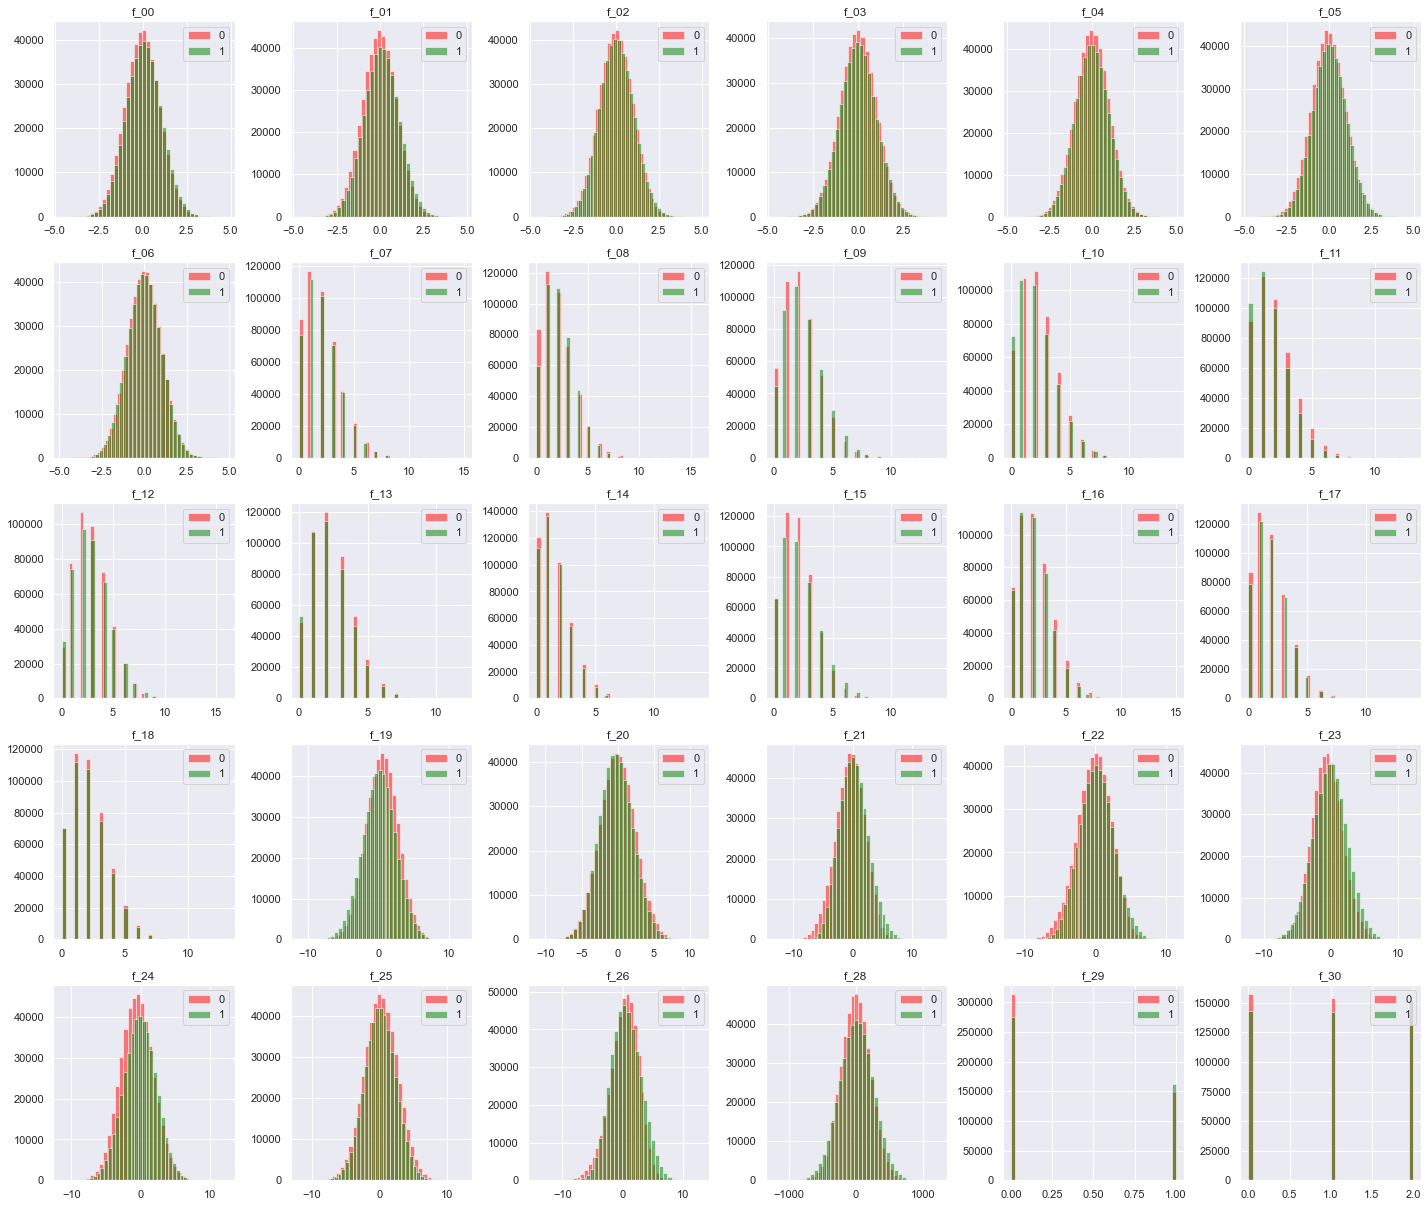

In [51]:
plot_distributions_binary_target(train, remove_cols=('id', 'target'))

In [4]:
plot_corr_with_target(train)

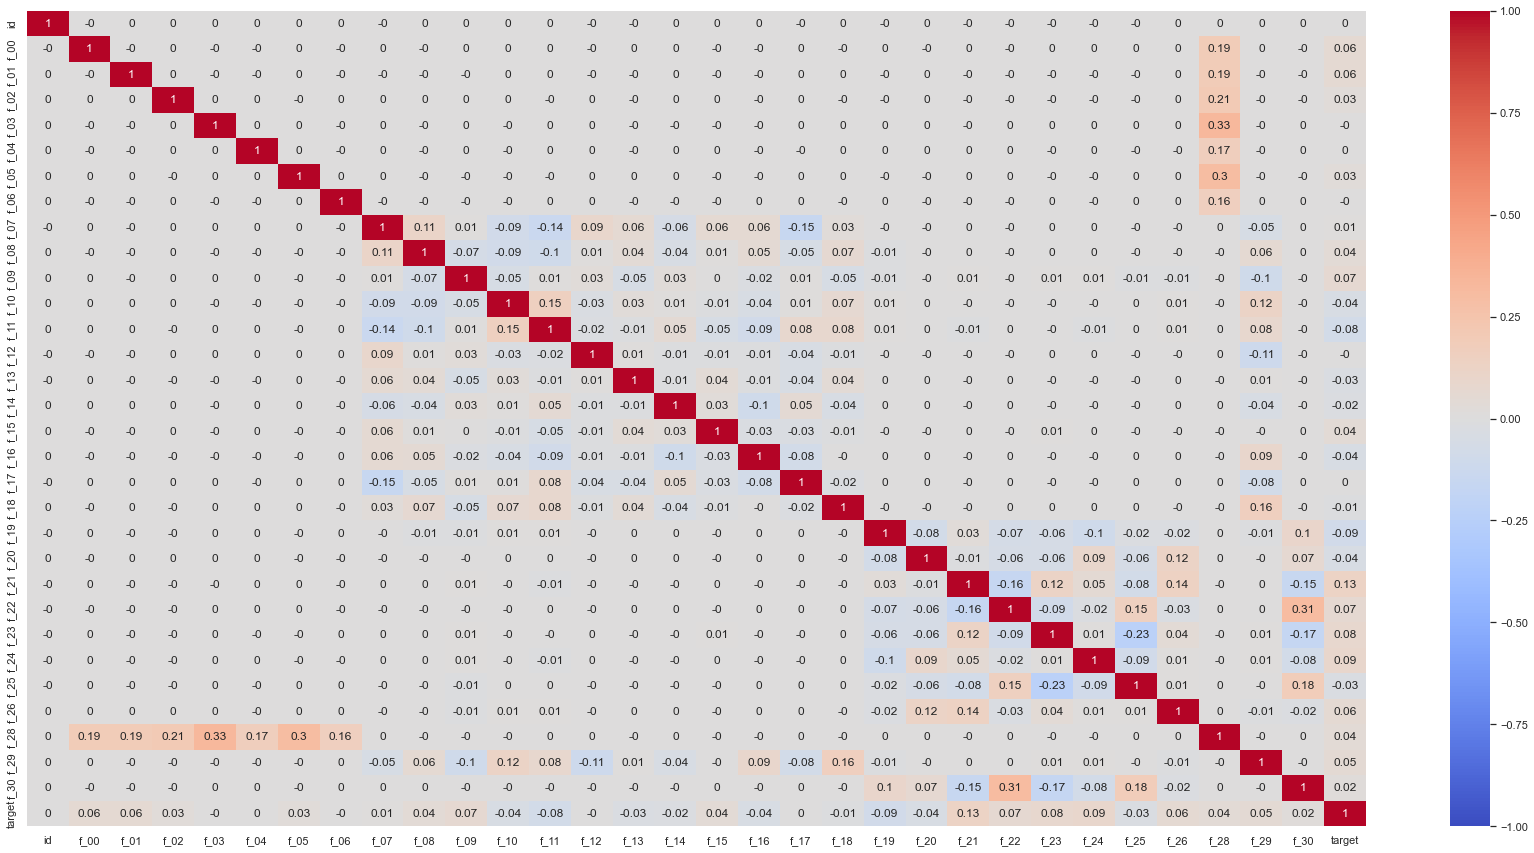

In [7]:
corr = train.corr().round(2)
plt.figure(figsize=(30,15))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

# Feature engineering

### Feature_27

In [14]:
train.f_27.head()

0    ABABDADBAB
1    ACACCADCEB
2    AAAEABCKAD
3    BDBBAACBCB
4    BDBCBBCHFE
Name: f_27, dtype: category
Categories (741354, object): ['AAAAAAABAB', 'AAAAAAABAC', 'AAAAAAACAB', 'AAAAAAAEAA', ..., 'BLBCBBELDC', 'BLBFBBBJDC', 'BMBACACHCD', 'BMBDEADPAC']

In [5]:
def pipeline_char_count(input_df):
    for i in range(10):
        input_df[f'ch{i}'] = input_df.f_27.str.get(i).apply(ord) - ord('A')

    return input_df

def pipeline_unique_chars(input_df):
    input_df["unique_characters"] = input_df.f_27.apply(lambda s: len(set(s)))

    # drop original f_27
    input_df.drop(['f_27'], axis=1, inplace=True)

    return input_df

### Additional numeric features

In [6]:
def pipeline_numeric_feature_combinations(input_df):
    input_df['i_02_21'] = (input_df.f_21 + input_df.f_02 > 5.2).astype(int) - (input_df.f_21 + input_df.f_02 < -5.3).astype(int)
    input_df['i_05_22'] = (input_df.f_22 + input_df.f_05 > 5.1).astype(int) - (input_df.f_22 + input_df.f_05 < -5.4).astype(int)
    i_00_01_26 = input_df.f_00 + input_df.f_01 + input_df.f_26
    input_df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

    return input_df

def pipeline_numeric_auto_generated(input_df):
    input_df['f_24*exp(-f_30)'] = input_df['f_24'] * np.exp(-input_df['f_30'])
    input_df['1/(exp(i_00_01_26) + exp(i_05_22))'] = 1 / (np.exp(input_df['i_00_01_26']) + np.exp(input_df['i_05_22']))
    input_df['log(exp(i_00_01_26)*exp(i_02_21))'] = np.log(np.exp(input_df['i_00_01_26']) * np.exp(input_df['i_02_21']))
    input_df['log(exp(i_02_21)*exp(i_05_22))'] =  np.log(np.exp(input_df['i_02_21']) * np.exp(input_df['i_05_22']))
    input_df['1/(i_00_01_26**2 + exp(i_02_21))'] = 1 / (input_df['i_00_01_26']**2 + np.exp(input_df['i_02_21']))

    return input_df

### Additional char features

In [7]:
def pipeline_char_auto_generated(input_df):
    input_df['Abs(ch2 - sqrt(ch9))'] = np.abs(input_df['ch2'] - np.sqrt(input_df['ch9']))
    input_df['Abs(sqrt(ch6) - sqrt(ch7))'] = np.abs(np.sqrt(input_df['ch6']) - np.sqrt(input_df['ch7']))
    input_df['sqrt(ch5 + sqrt(ch8))'] = np.sqrt(input_df['ch5'] + np.sqrt(input_df['ch8']))
    input_df['Abs(sqrt(ch3) - sqrt(ch7))'] = np.abs(np.sqrt(input_df['ch3']) - np.sqrt(input_df['ch7']))

    return input_df

In [8]:
features = [f for f in test.columns if f != 'id' and f != 'f_27']

### Autofeature

In [9]:
all_features = [f for f in train.columns if f != 'f_27']
train_smp = train[all_features].sample(1000, random_state=2022)
train_smp_x = train_smp.drop(['target'],axis=1)
train_smp_y = train_smp.target

train_smp.shape, train_smp_x.shape, train_smp_y.shape

((1000, 46), (1000, 45), (1000,))

In [10]:
%%time

model = AutoFeatRegressor(verbose=2,
                          n_jobs=1,
                          feateng_steps=3,
                          featsel_runs=6)

train_smp_x_feature_creation = model.fit_transform(train_smp_x, train_smp_y)
train_smp_x_feature_creation.head()

[AutoFeat] The 3 step feature engineering process could generate up to 1236690 features.
[AutoFeat] With 1000 data points this new feature matrix would use about 4.95 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 175 transformed features from 45 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 95635 feature combinations from 24090 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 337213 transformed features from 95635 original features - done.
[feateng] Generated altogether 451389 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 316752 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/6
[featsel]	 11 initial features.
[featsel]	 Split 737/737: 6627 candidate features identified.
[featsel]	 Selected  51 features after noise filteri

id      f_00      f_01      f_02      f_03      f_04      f_05  \
0  703964.0  1.521484  0.250977  2.007812  0.501953 -0.777344  0.604980   
1  334107.0  0.978027 -0.567871 -0.366943  0.207642  0.103821 -1.581055   
2  543675.0 -0.385986 -1.032227  0.091370 -0.495850 -0.247681  0.269531   
3  727151.0  2.044922  0.943359  1.327148  1.321289 -0.557617  1.090820   
4  385733.0 -2.142578  0.285889 -0.933594 -0.408447 -1.072266 -1.709961   

       f_06  f_07  f_08  ...  exp(-i_02_21)/log(unique_characters)  \
0 -0.061371   0.0   0.0  ...                              0.721348   
1  1.139648   2.0   4.0  ...                              0.621335   
2 -1.045898   6.0   2.0  ...                              0.621335   
3  0.381104   2.0   4.0  ...                              0.721348   
4 -0.833008   1.0   1.0  ...                              0.621335   

   1/(-exp(i_05_22) + log(unique_characters))  Abs(f_15 + f_23)  \
0                                    2.588699          0.867188   
1                                    1.640856          2.185547   
2                                    1.640856          0.164062   
3                                    2.588699          2.375000   
4                                    1.640856          0.718750   

   1/(ch1**2 + exp(ch3))  1/(exp(ch8) + exp(ch9))  log(exp(ch1)*exp(f_19))  \
0               0.268941                 0.002462                 0.093750   
1               0.367879                 0.017447                 0.816406   
2               0.030875                 0.000895                 9.148438   
3               0.119203                 0.098938                 5.371094   
4               0.041519                 0.119203                 4.853516   

   (sqrt(ch6) - sqrt(ch9))**3  (sqrt(ch6) - unique_characters)**3  \
0                   -3.045408                          -27.000000   
1                    1.888544                          -21.114562   
2                   -0.032108                          -46.105556   
3                   -1.000000                          -64.000000   
4                   -0.071068                          -64.000000   

   (-sqrt(ch1) + unique_characters)**3  (f_19**3 - unique_characters**3)**2  
0                            27.000000                          4191.823504  
1                           125.000000                         15489.258497  
2                            21.114562                          2873.745302  
3                            27.000000                           380.879345  
4                            46.105556                         10356.136044  

[5 rows x 70 columns]

### Produce whole pipeline

In [46]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [47]:
pipeline = Pipeline([
    ("char_count", DataframeFunctionTransformer(pipeline_char_count)),
    ("char_unique", DataframeFunctionTransformer(pipeline_unique_chars)),
    ("numeric_combinations", DataframeFunctionTransformer(pipeline_numeric_feature_combinations)),
    ("numeric_auto", DataframeFunctionTransformer(pipeline_numeric_auto_generated)),
    ("char_auto", DataframeFunctionTransformer(pipeline_char_auto_generated)),
    ('scale', StandardScaler())
    #('reduce_dims', PCA(n_components=15)),
])

In [57]:
train_features = train.copy()
train_features.drop(['id', 'target'], axis=1, inplace=True)
train_targets = train['target'].copy()

test_features = test.copy()
test_features.drop(['id'], axis=1, inplace=True)

pipeline.fit_transform(train_features, train_targets)
pipeline.transform(test_features)

features = train_features.columns

train_features.shape, test_features.shape

((900000, 53), (700000, 53))

# Saving features

In [26]:
np.savez_compressed("features/train_features_1.npz", np.asarray(train_features))
np.savez_compressed("features/test_features_1.npz", np.asarray(test_features))

### Train, evaluatioin, test as numpy array

In [59]:
train_prep, train_targets, eval_prep, eval_targets = train_test_split(train_features, np.asarray(train_targets), test_size=0.2)
test_prep = test_features.copy()

train_prep.shape, train_targets.shape, eval_prep.shape, eval_targets.shape, test_prep.shape

((720000, 53), (720000,), (180000, 53), (180000,), (700000, 53))

### Describe training data

In [60]:
train_eda = pd.DataFrame(train_features, columns=features)
train_eda['target'] = train.target

train_eda.head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0 -1.374290  0.237919 -0.244457  0.568652 -0.647271  0.839176  0.113875   
1  1.699443 -1.712509 -2.230496 -0.544435  1.113667 -1.552237  0.448489   
2  1.683800  0.616032 -1.027989  0.811774 -0.608215  0.113682 -0.707828   
3 -0.118009 -0.589532 -0.805448  2.086943  0.371603 -0.129085 -0.281778   
4  1.150003 -0.177822 -0.665871 -1.100002  0.468266  0.499778  0.408204   

       f_07      f_08      f_09  ...  f_24*exp(-f_30)  \
0 -0.622798  1.849207 -0.831915  ...        -1.835180   
1 -0.622798  0.592099  0.999917  ...        -0.782783   
2 -0.622798 -1.293562 -0.221304  ...         0.062351   
3  0.584807 -0.036455 -0.831915  ...         1.235105   
4  0.584807  0.592099 -1.442525  ...         0.607401   

   1/(exp(i_00_01_26) + exp(i_05_22))  log(exp(i_00_01_26)*exp(i_02_21))  \
0                            0.053754                          -0.033253   
1                            0.053754                          -0.033253   
2                            0.053754                          -0.033253   
3                            0.053754                          -0.033253   
4                           -2.717974                           2.664133   

   log(exp(i_02_21)*exp(i_05_22))  1/(i_00_01_26**2 + exp(i_02_21))  \
0                         0.00766                          0.035958   
1                         0.00766                          0.035958   
2                         0.00766                          0.035958   
3                         0.00766                          0.035958   
4                         0.00766                         -1.535920   

   Abs(ch2 - sqrt(ch9))  Abs(sqrt(ch6) - sqrt(ch7))  sqrt(ch5 + sqrt(ch8))  \
0              0.329386                   -0.936366              -2.573478   
1              0.329386                   -1.348108               0.415074   
2              1.584917                    0.073586              -0.460253   
3             -1.385702                   -1.252307              -0.060416   
4              0.329386                   -0.439859               1.228019   

   Abs(sqrt(ch3) - sqrt(ch7))  target  
0                   -1.694564       0  
1                   -1.694564       1  
2                   -0.604119       1  
3                   -1.694564       1  
4                   -0.539139       1  

[5 rows x 54 columns]

In [64]:
train_eda.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
    .background_gradient(subset=['min'], cmap='Greens')\
    .background_gradient(subset=['50%'], cmap='BuGn')

### Visualizing chars

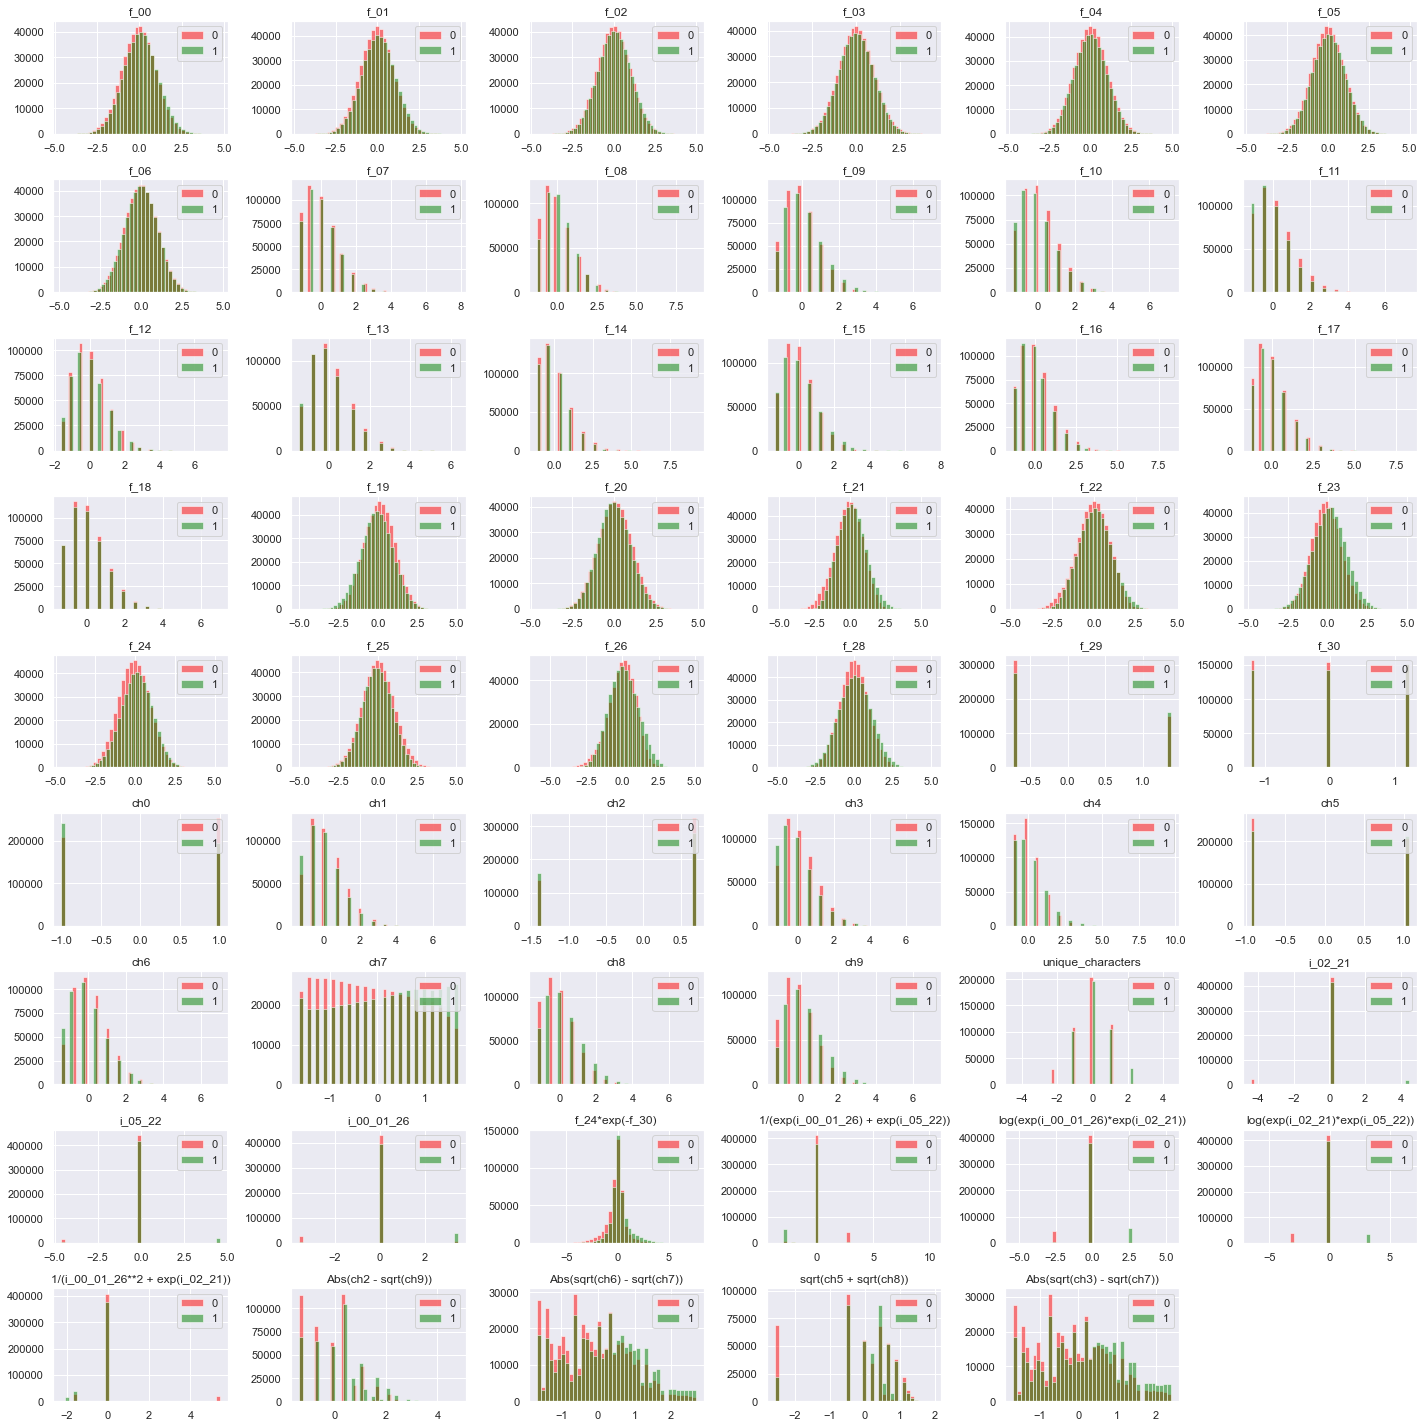

In [66]:
plot_distributions_binary_target(train_eda, remove_cols=('target'))

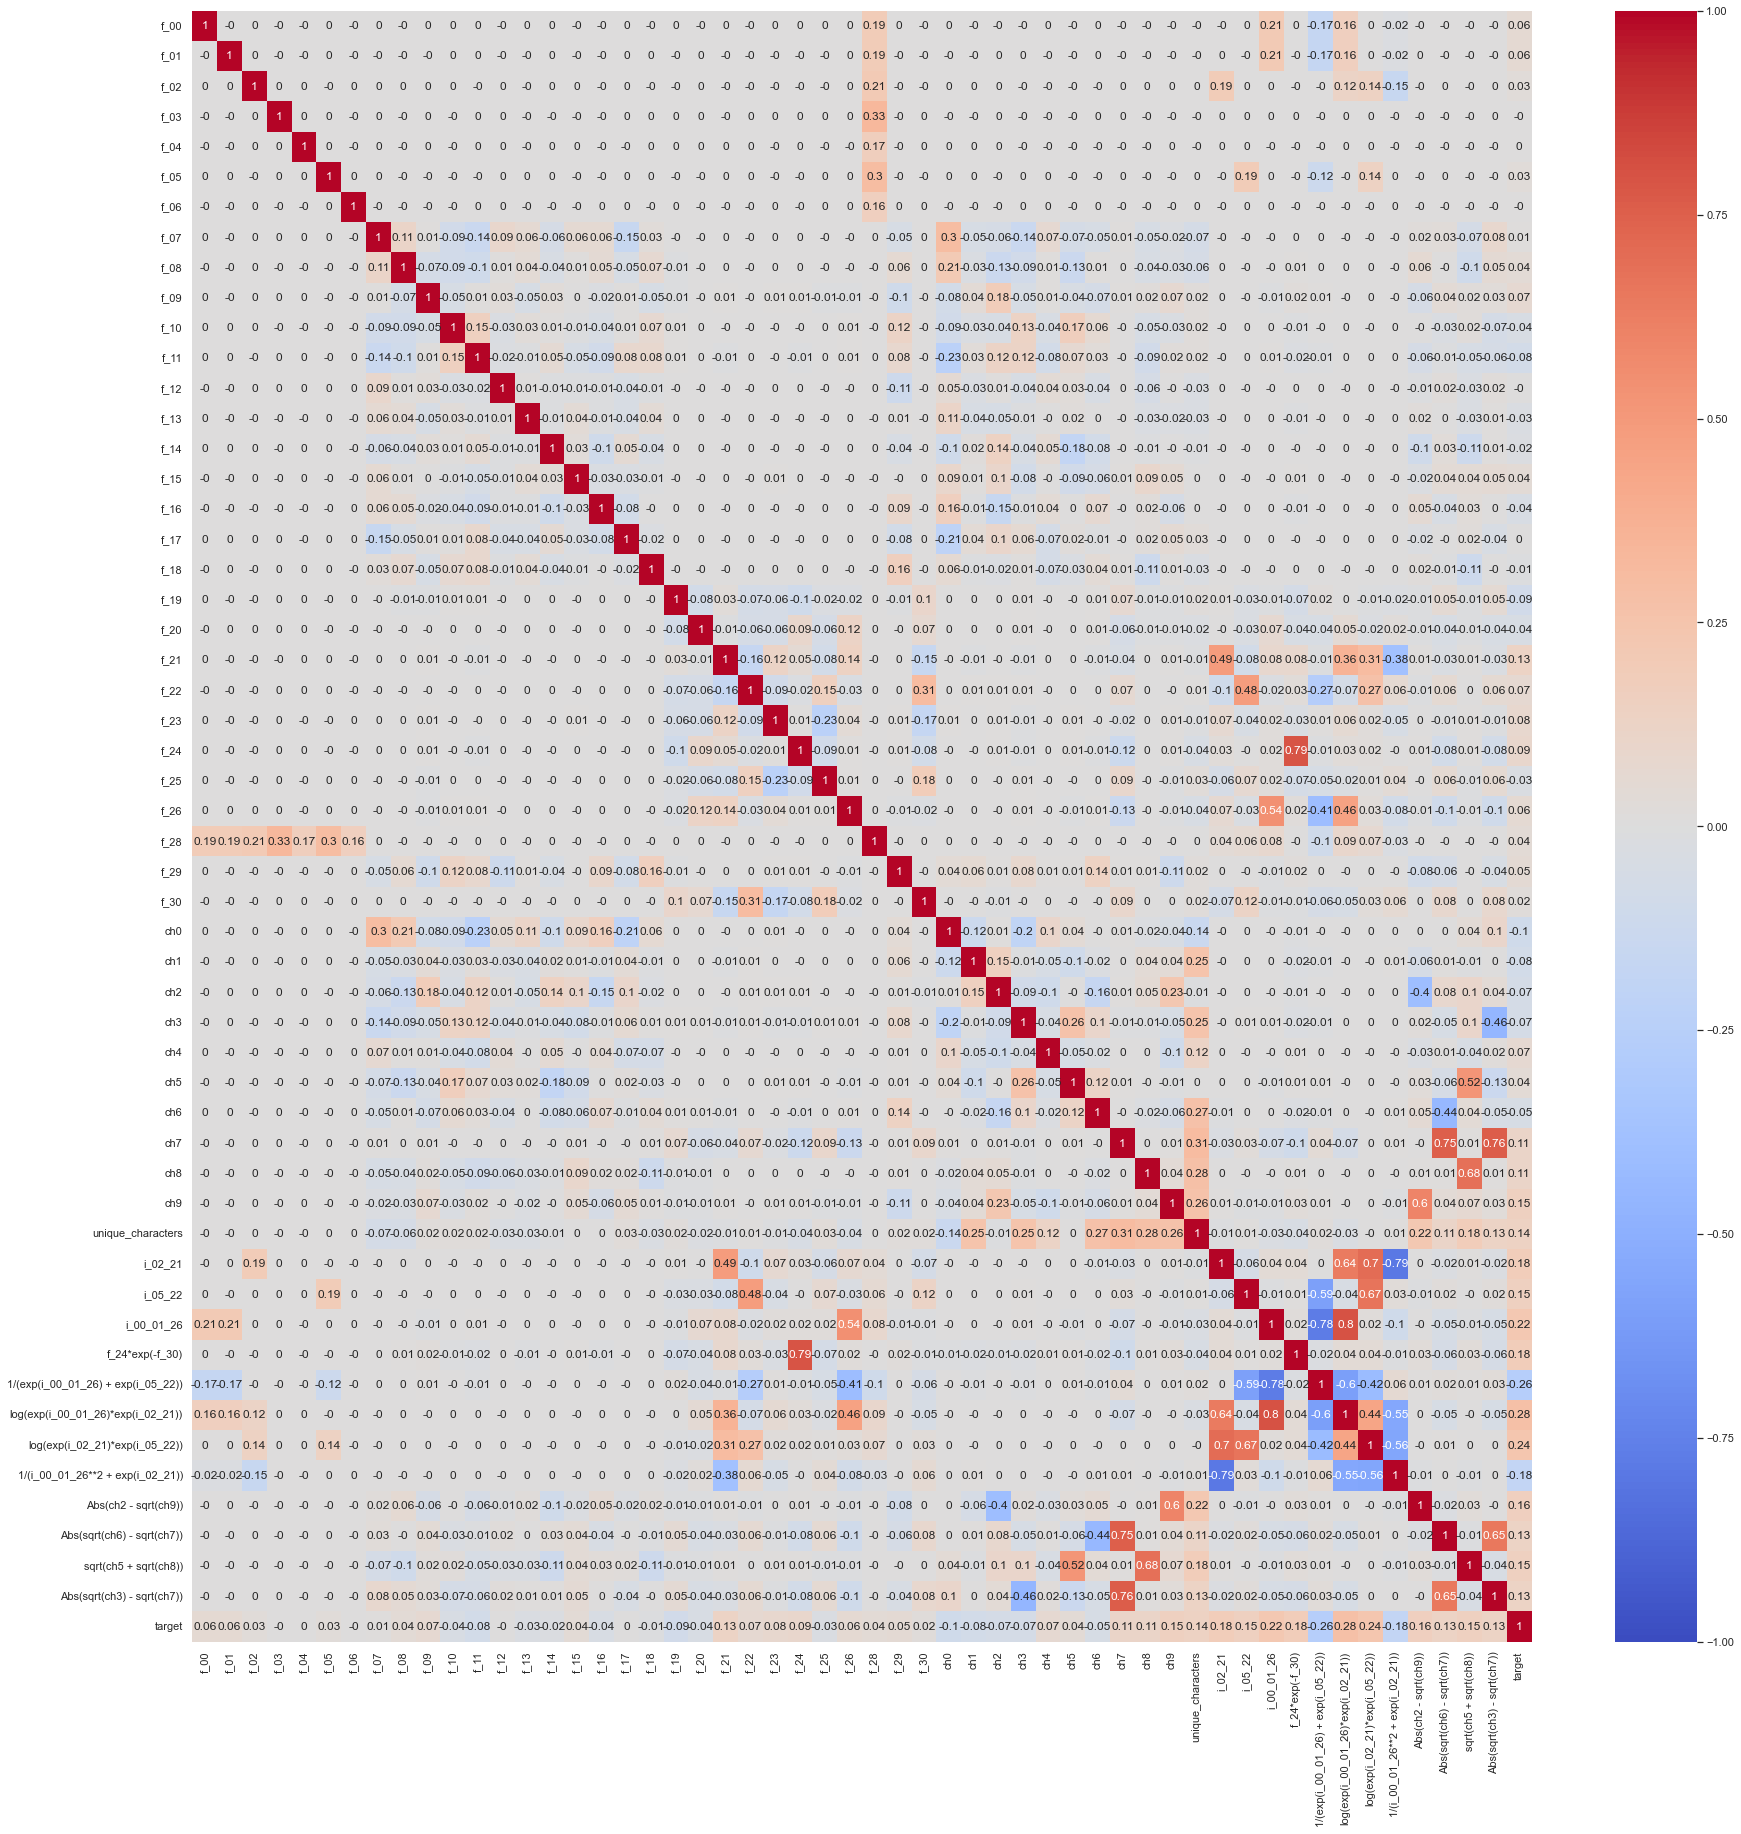

In [67]:
corr = train_eda.corr().round(2)
plt.figure(figsize=(30,30))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

# Model - simple DNN

### Parameters

In [86]:
EPOCHS_TUNER = 15
EPOCHS_FINE = 25
BATCH_SIZE_TUNER = 1024
BATCH_SIZE_FINE = 1024*2
LEARNING_RATE_START = 0.01
LEARNING_RATE_END = 5e-5
MAX_TRIALS = 50

DENSE_LAYER_MIN_SIZE = 64 #64
DENSE_LAYER_MAX_SIZE = 512 #256
DENSE_LAYER_STEP_SIZE = 64 #64

### Model & keras tuner

In [81]:
def build_model_dense1(hp):


    activation_list = ['swish',
                       'relu',
                       'elu',
                       'tanh']

    inputs = Input(shape=len(features))
    x = Dense(units=hp.Int("units_dense_1", min_value=DENSE_LAYER_MIN_SIZE, max_value=DENSE_LAYER_MAX_SIZE, step=DENSE_LAYER_STEP_SIZE), kernel_regularizer=tf.keras.regularizers.l2(30e-6),
              activation=activation_list[hp.Choice("activation_1", values=[0,1,2,3])],
              )(inputs)
    x = Dense(units=hp.Int("units_dense_2", min_value=DENSE_LAYER_MIN_SIZE, max_value=DENSE_LAYER_MAX_SIZE, step=DENSE_LAYER_STEP_SIZE), kernel_regularizer=tf.keras.regularizers.l2(30e-6),
              activation=activation_list[hp.Choice("activation_2", values=[0,1,2,3])],
              )(x)
    x = Dense(units=hp.Int("units_dense_3", min_value=DENSE_LAYER_MIN_SIZE, max_value=DENSE_LAYER_MAX_SIZE, step=DENSE_LAYER_STEP_SIZE), kernel_regularizer=tf.keras.regularizers.l2(30e-6),
              activation=activation_list[hp.Choice("activation_3", values=[0,1,2,3])],
              )(x)
    x = Dense(units=hp.Int("units_dense_3", min_value=DENSE_LAYER_MIN_SIZE, max_value=DENSE_LAYER_MAX_SIZE, step=DENSE_LAYER_STEP_SIZE), kernel_regularizer=tf.keras.regularizers.l2(30e-6),
              activation=activation_list[hp.Choice("activation_3", values=[0,1,2,3])],
              )(x)
    x = Dense(units=hp.Int("units_dense_3", min_value=DENSE_LAYER_MIN_SIZE, max_value=DENSE_LAYER_MAX_SIZE, step=DENSE_LAYER_STEP_SIZE), kernel_regularizer=tf.keras.regularizers.l2(30e-6),
              activation=activation_list[hp.Choice("activation_3", values=[0,1,2,3])],
              )(x)

    x = Dropout(hp.Float("dropout_rate_dense_1", min_value=0.2, max_value=0.5, step=0.1))(x)

    x = Dense(1, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              activation='sigmoid',
              )(x)
    model = Model(inputs, x)

    optimizier_list=[tf.keras.optimizers.Adam,
                     tf.keras.optimizers.RMSprop,
                     tf.keras.optimizers.Nadam,
                     tf.keras.optimizers.Adagrad]

    #hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4, 5e-5])
    hp_optimizer = hp.Choice("optimizer", values=[0,1,2,3])

    model.compile(loss='binary_crossentropy', optimizer=optimizier_list[hp_optimizer](learning_rate=LEARNING_RATE_START), metrics=['AUC'])

    return model

#plot_model(build_model_dense1(), show_layer_names=False, show_shapes=True)

In [18]:
tuner = get_tuner(build_model_dense1, 'bayesian', max_trials=MAX_TRIALS)

Getting Bayesian keras tuner..
Search space summary
Default search space size: 8
units_dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
activation_1 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
units_dense_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
activation_2 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
units_dense_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
activation_3 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
dropout_rate_dense_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
optimizer (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}


### Callbacks

In [19]:
# Early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Learning rate cosine decay
def cosine_decay_tuner(epoch):
    if EPOCHS_TUNER > 1:
        w = (1 + math.cos(epoch / (EPOCHS_TUNER-1) * math.pi)) / 2
    else:
        w = 1
    return w * LEARNING_RATE_START + (1 - w) * LEARNING_RATE_END

lr_tuner = LearningRateScheduler(cosine_decay_tuner, verbose=0)

def cosine_decay_fine(epoch):
    if EPOCHS_TUNER > 1:
        w = (1 + math.cos(epoch / (EPOCHS_FINE-1) * math.pi)) / 2
    else:
        w = 1
    return w * LEARNING_RATE_START + (1 - w) * LEARNING_RATE_END

lr_fine = LearningRateScheduler(cosine_decay_fine, verbose=0)

# Terminate on NaN
terminate_nan = tf.keras.callbacks.TerminateOnNaN()

# All callbacks
callbacks_tuner = [stop_early, lr_tuner, terminate_nan]
callbacks_fine = [stop_early, lr_fine, terminate_nan]

### Training - tuning

In [20]:
xtrain = train_prep
kf = KFold(n_splits=5, random_state=2022, shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(xtrain)):
    X_train = xtrain[idx_tr]
    y_train = train_targets[idx_tr]
    X_val = xtrain[idx_va]
    y_val = train_targets[idx_va]

    tuner.search(X_train, y_train, validation_data = (X_val, y_val), epochs=EPOCHS_TUNER, callbacks=callbacks_tuner, verbose=2, batch_size = BATCH_SIZE_TUNER, use_multiprocessing=True)

    break # we only need the first fold

Trial 50 Complete [00h 00m 23s]
val_auc: 0.9578006267547607

Best val_auc So Far: 0.9972394704818726
Total elapsed time: 00h 31m 15s
INFO:tensorflow:Oracle triggered exit


In [21]:
%%time

train_pred_tuner_models(tuner, build_model_dense1, train_prep, train_targets, test_prep, ids, n_models=1, n_folds=8, random_seed=True, save_model=True, eval_x=eval_prep, callbacks=callbacks_fine, epochs=EPOCHS_FINE, batch_size=BATCH_SIZE_FINE)

Epoch 1/25
282/282 - 1s - loss: 0.2124 - auc: 0.9776 - val_loss: 0.1536 - val_auc: 0.9901
Epoch 2/25
282/282 - 1s - loss: 0.1344 - auc: 0.9924 - val_loss: 0.1300 - val_auc: 0.9934
Epoch 3/25
282/282 - 1s - loss: 0.1199 - auc: 0.9942 - val_loss: 0.1260 - val_auc: 0.9933
Epoch 4/25
282/282 - 1s - loss: 0.1129 - auc: 0.9949 - val_loss: 0.1199 - val_auc: 0.9944
Epoch 5/25
282/282 - 1s - loss: 0.1069 - auc: 0.9954 - val_loss: 0.1104 - val_auc: 0.9951
Epoch 6/25
282/282 - 1s - loss: 0.1041 - auc: 0.9956 - val_loss: 0.1082 - val_auc: 0.9952
Epoch 7/25
282/282 - 1s - loss: 0.1002 - auc: 0.9959 - val_loss: 0.1040 - val_auc: 0.9955
Epoch 8/25
282/282 - 1s - loss: 0.0975 - auc: 0.9961 - val_loss: 0.1005 - val_auc: 0.9960
Epoch 9/25
282/282 - 1s - loss: 0.0950 - auc: 0.9964 - val_loss: 0.0974 - val_auc: 0.9962
Epoch 10/25
282/282 - 1s - loss: 0.0914 - auc: 0.9966 - val_loss: 0.0961 - val_auc: 0.9961
Epoch 11/25
282/282 - 1s - loss: 0.0900 - auc: 0.9967 - val_loss: 0.0973 - val_auc: 0.9961
Epoch 12

# Model - XGBoost

In [69]:
train_prep.shape, train_targets.shape, eval_prep.shape, eval_targets.shape, test_prep.shape

((720000, 53), (720000,), (180000, 53), (180000,), (700000, 53))

### Hyperopt

In [19]:
kf = KFold(n_splits=6, random_state=2022, shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_prep)):
    X_train = train_prep[idx_tr]
    y_train = train_targets[idx_tr]
    X_val = train_prep[idx_va]
    y_val = train_targets[idx_va]

    break

# samples_for_tuning = X_train.shape[0] // 4
#
# X_train = X_train[:samples_for_tuning]
# y_train = y_train[:samples_for_tuning]
# X_val = X_val[:samples_for_tuning//5]
# y_val = y_val[:samples_for_tuning//5]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((600000, 60), (600000,), (120000, 60), (120000,))

In [20]:
space={'max_depth': scope.int(hp.quniform("max_depth", 8, 15, 1)),
       'gamma': hp.uniform ('gamma', 0.5,5),
       'reg_alpha' : hp.uniform('reg_alpha', 1,5),
       'reg_lambda' : hp.uniform('reg_lambda', 1,5),
       'colsample_bytree' : hp.uniform ('colsample_bytree', 0.5,0.9),
       'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
       'n_estimators': scope.int(hp.quniform("n_estimators", 512, 2048, 1)),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
       'subsample': hp.uniform('subsample', 0.5, 1),
       'objective': hp.choice('objective', ['binary:logistic']),
       'tree_method': hp.choice('tree_method', ['gpu_hist']),
       }

In [21]:
def xgb_objective(space):
    model=XGBClassifier(
        n_estimators = space['n_estimators'],
        max_depth = space['max_depth'],
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        reg_lambda = space['reg_lambda'],
        min_child_weight=space['min_child_weight'],
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        objective=space['objective'],
        tree_method=space['tree_method'],
        colsample_bytree=space['colsample_bytree'])

    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)

    pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, pred)
    #accuracy = accuracy_score(y_val, pred>0.5)
    #print (f"ROC_AUC SCORE: {score} | ACCURACY SCORE: {accuracy}")
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [22]:
trials = Trials()

best_hyperparams = fmin(fn = xgb_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 70,
                        trials = trials)

best_hyperparams = space_eval(space, best_hyperparams)

100%|██████████| 70/70 [46:01<00:00, 39.45s/trial, best loss: -0.9961986841429863] 


In [23]:
xgb = XGBClassifier(**best_hyperparams)
hist = xgb.fit(X_train, y_train,
               eval_set = [(X_val, y_val)],
               eval_metric = ['auc', 'logloss'],
               early_stopping_rounds = 100,
               verbose = 100)

[0]	validation_0-auc:0.81814	validation_0-logloss:0.67530
[100]	validation_0-auc:0.98300	validation_0-logloss:0.22670
[200]	validation_0-auc:0.99049	validation_0-logloss:0.15551
[300]	validation_0-auc:0.99260	validation_0-logloss:0.12979
[400]	validation_0-auc:0.99407	validation_0-logloss:0.11242
[500]	validation_0-auc:0.99490	validation_0-logloss:0.10130
[600]	validation_0-auc:0.99551	validation_0-logloss:0.09305
[700]	validation_0-auc:0.99580	validation_0-logloss:0.08851
[800]	validation_0-auc:0.99598	validation_0-logloss:0.08530
[900]	validation_0-auc:0.99609	validation_0-logloss:0.08343
[1000]	validation_0-auc:0.99620	validation_0-logloss:0.08166
[1100]	validation_0-auc:0.99621	validation_0-logloss:0.08121
[1200]	validation_0-auc:0.99623	validation_0-logloss:0.08078
[1300]	validation_0-auc:0.99623	validation_0-logloss:0.08067
[1400]	validation_0-auc:0.99626	validation_0-logloss:0.08017
[1500]	validation_0-auc:0.99627	validation_0-logloss:0.07992
[1557]	validation_0-auc:0.99628	vali

(-1.0, -0.99)

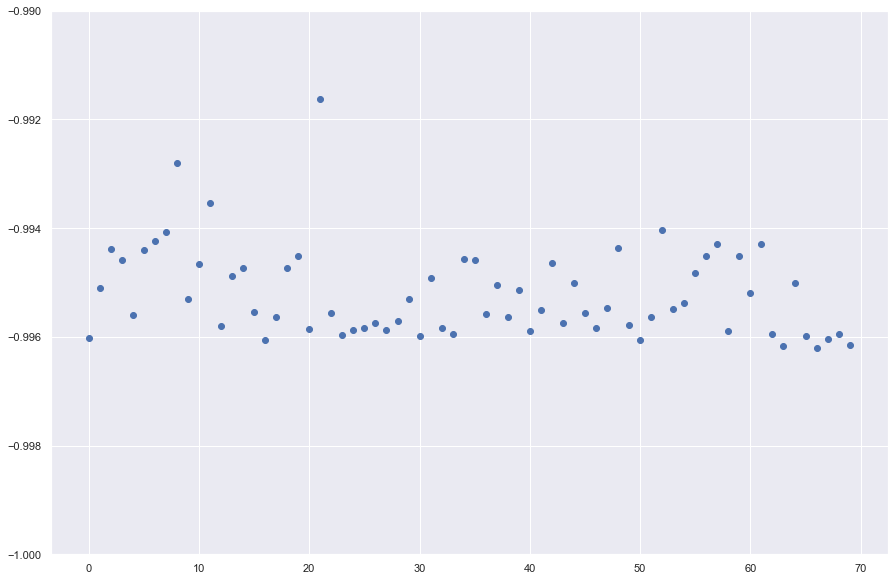

In [24]:
# Extract and plot the trials losses
plt.scatter(range(len(trials.losses())), trials.losses())
ax = plt.gca()
ax.set_ylim([-1, -0.99])

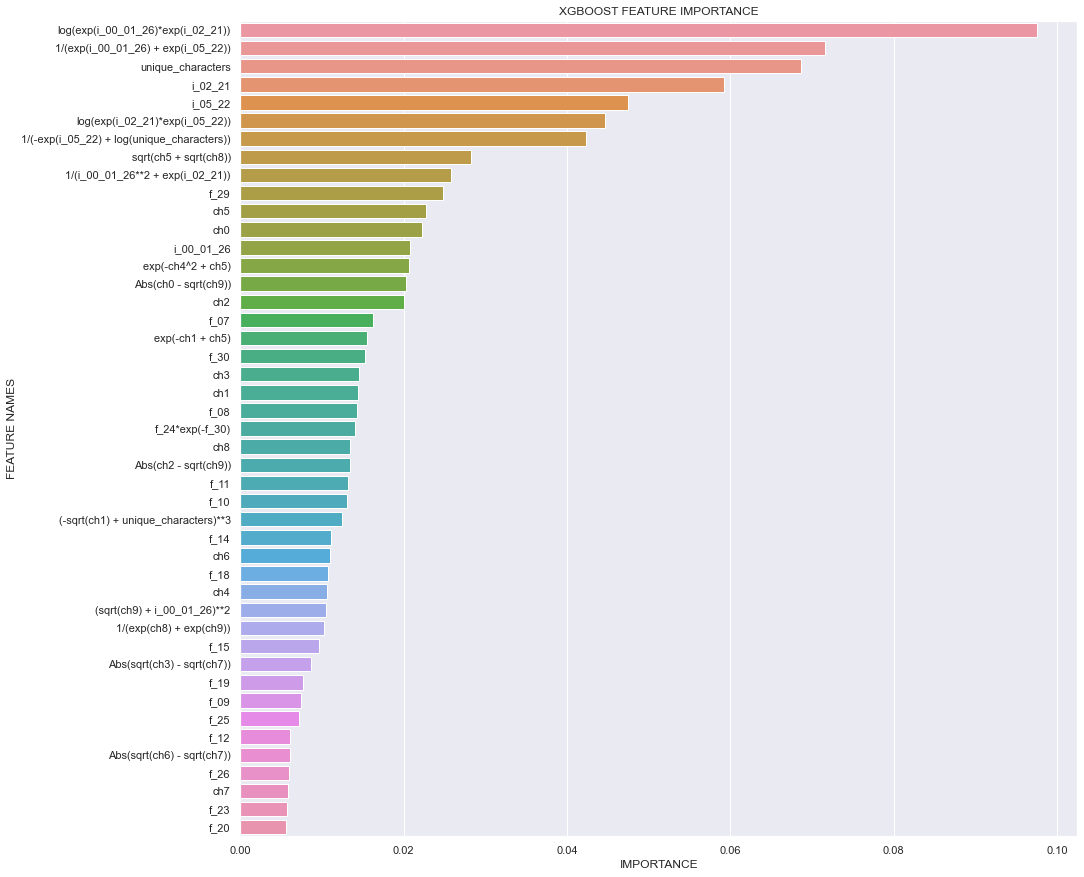

In [25]:
plot_feature_importance(xgb.feature_importances_, features, 'XGBOOST ', max_features=45)

In [26]:
fit_parameters = {'early_stopping_rounds': 100,
                  'verbose': 100,
                  'eval_metric': ['auc', 'logloss']
                  }
train_pred_hyperopt_model([best_hyperparams], [XGBClassifier], train_prep, train_targets, test_prep, ids, model_fit_parameters=[fit_parameters], n_folds=8, random_seed=True, save_model=True, eval_x=eval_prep)

Fold: 1/8
[0]	validation_0-auc:0.81120	validation_0-logloss:0.67568
[100]	validation_0-auc:0.98370	validation_0-logloss:0.22435
[200]	validation_0-auc:0.99059	validation_0-logloss:0.15532
[300]	validation_0-auc:0.99282	validation_0-logloss:0.12840
[400]	validation_0-auc:0.99392	validation_0-logloss:0.11353
[500]	validation_0-auc:0.99485	validation_0-logloss:0.10174
[600]	validation_0-auc:0.99540	validation_0-logloss:0.09418
[700]	validation_0-auc:0.99571	validation_0-logloss:0.08933
[800]	validation_0-auc:0.99588	validation_0-logloss:0.08644
[900]	validation_0-auc:0.99598	validation_0-logloss:0.08462
[1000]	validation_0-auc:0.99608	validation_0-logloss:0.08308
[1100]	validation_0-auc:0.99612	validation_0-logloss:0.08236
[1200]	validation_0-auc:0.99616	validation_0-logloss:0.08165
[1300]	validation_0-auc:0.99618	validation_0-logloss:0.08127
[1400]	validation_0-auc:0.99620	validation_0-logloss:0.08087
[1500]	validation_0-auc:0.99621	validation_0-logloss:0.08066
[1557]	validation_0-auc:0.

# Model - LGBM

In [27]:
train_prep.shape, train_targets.shape, eval_prep.shape, eval_targets.shape, test_prep.shape

((720000, 60), (720000,), (180000, 60), (180000,), (700000, 60))

### Hyperopt

In [28]:
kf = KFold(n_splits=6, random_state=2022, shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_prep)):
    X_train = train_prep[idx_tr]
    y_train = train_targets[idx_tr]
    X_val = train_prep[idx_va]
    y_val = train_targets[idx_va]

    break

# samples_for_tuning = X_train.shape[0] // 3
#
# X_train = X_train[:samples_for_tuning]
# y_train = y_train[:samples_for_tuning]
# X_val = X_val[:samples_for_tuning//5]
# y_val = y_val[:samples_for_tuning//5]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((600000, 60), (600000,), (120000, 60), (120000,))

In [29]:
space={'max_depth': scope.int(hp.quniform("max_depth", 8, 15, 1)),
       'reg_alpha' : hp.uniform('reg_alpha', 2,8),
       'reg_lambda' : hp.uniform('reg_lambda', 2,8),
       'colsample_bytree' : hp.uniform ('colsample_bytree', 0.7,0.9),
       'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
       'n_estimators': scope.int(hp.quniform("n_estimators", 1024, 4096, 1)),
       'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
       'subsample': hp.uniform('subsample', 0.5, 1),
       'objective': hp.choice('objective', ['binary']),
       'device_type': hp.choice('device_type', ['gpu']),
       'gpu_use_dp': hp.choice('gpu_use_dp', [False])
       }

In [30]:
best_hyperparams

{'colsample_bytree': 0.8162892065573131,
 'gamma': 1.2762061691207287,
 'learning_rate': 0.05762352789132326,
 'max_depth': 10,
 'min_child_weight': 8,
 'n_estimators': 1558,
 'objective': 'binary:logistic',
 'reg_alpha': 3.1319893000203405,
 'reg_lambda': 2.579325745857422,
 'subsample': 0.7376210773583827,
 'tree_method': 'gpu_hist'}

In [31]:
def lgbm_objective(space):
    model=LGBMClassifier(
        n_estimators = space['n_estimators'],
        max_depth = space['max_depth'],
        reg_alpha = space['reg_alpha'],
        reg_lambda = space['reg_lambda'],
        min_child_weight=space['min_child_weight'],
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        objective=space['objective'],
        device_type=space['device_type'],
        gpu_use_dp=space['gpu_use_dp'],
        colsample_bytree=space['colsample_bytree'])

    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)

    pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, pred)
    accuracy = accuracy_score(y_val, pred>0.5)
    #print (f"ROC_AUC SCORE: {score} | ACCURACY SCORE: {accuracy}")
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [32]:
trials = Trials()

best_hyperparams = fmin(fn = lgbm_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 60,
                        trials = trials)

best_hyperparams = space_eval(space, best_hyperparams)

100%|██████████| 60/60 [47:37<00:00, 47.62s/trial, best loss: -0.9960892687451925]


In [34]:
lgbm = LGBMClassifier(**best_hyperparams)
hist = lgbm.fit(X_train, y_train,
               eval_set = [(X_val, y_val)],
               eval_metric = ['auc', 'logloss'],
               early_stopping_rounds = 100,
               verbose = 100)

[100]	valid_0's auc: 0.976689	valid_0's binary_logloss: 0.252365
[200]	valid_0's auc: 0.986078	valid_0's binary_logloss: 0.184637
[300]	valid_0's auc: 0.98919	valid_0's binary_logloss: 0.156022
[400]	valid_0's auc: 0.991149	valid_0's binary_logloss: 0.138423
[500]	valid_0's auc: 0.99243	valid_0's binary_logloss: 0.126089
[600]	valid_0's auc: 0.993366	valid_0's binary_logloss: 0.116966
[700]	valid_0's auc: 0.993905	valid_0's binary_logloss: 0.111103
[800]	valid_0's auc: 0.994244	valid_0's binary_logloss: 0.107128
[900]	valid_0's auc: 0.994587	valid_0's binary_logloss: 0.103182
[1000]	valid_0's auc: 0.994791	valid_0's binary_logloss: 0.100476
[1100]	valid_0's auc: 0.995074	valid_0's binary_logloss: 0.0971023
[1200]	valid_0's auc: 0.995269	valid_0's binary_logloss: 0.0947013
[1300]	valid_0's auc: 0.995386	valid_0's binary_logloss: 0.0930986
[1400]	valid_0's auc: 0.995487	valid_0's binary_logloss: 0.0917469
[1500]	valid_0's auc: 0.995623	valid_0's binary_logloss: 0.0899496
[1600]	valid_0's

(-1.0, -0.99)

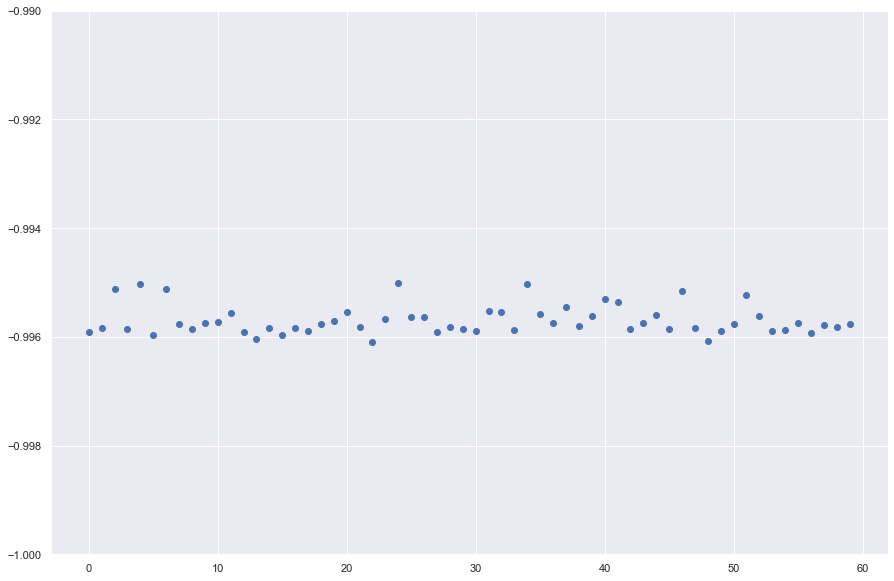

In [35]:
# Extract and plot the trials losses
plt.scatter(range(len(trials.losses())), trials.losses())
ax = plt.gca()
ax.set_ylim([-1, -0.99])

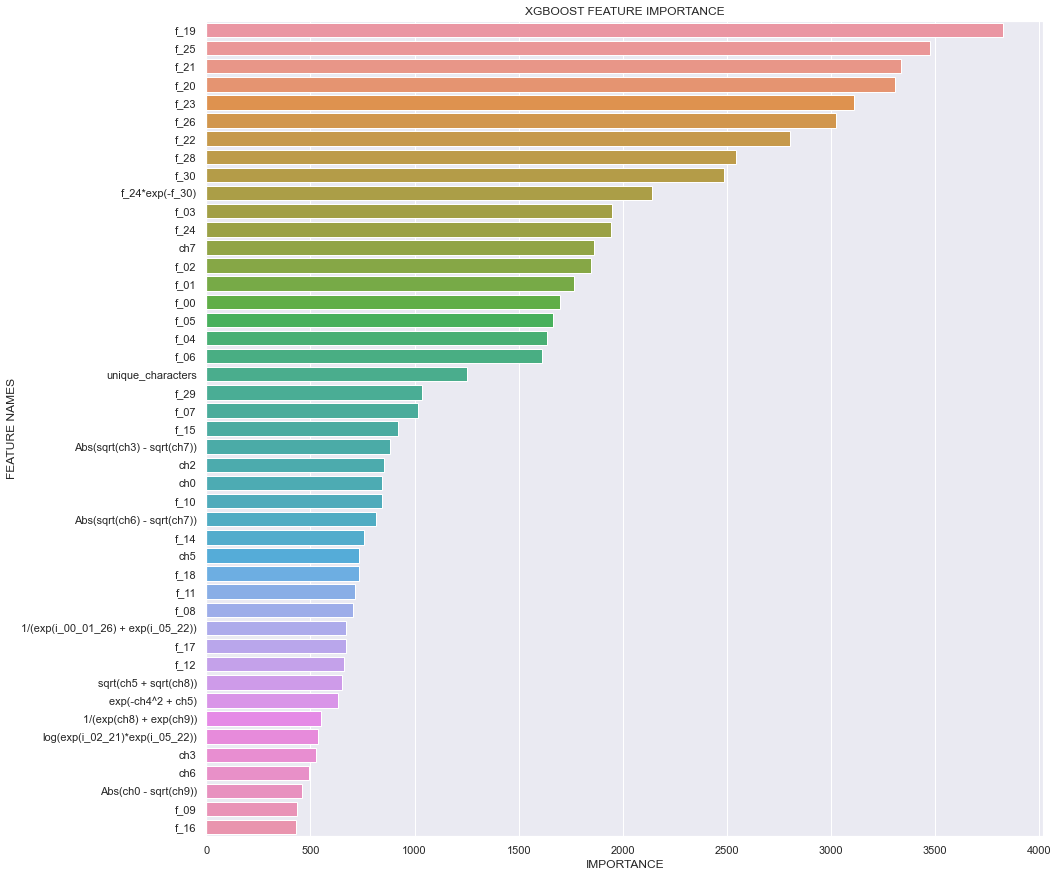

In [36]:
plot_feature_importance(lgbm.feature_importances_, features, 'XGBOOST ', max_features=45)

In [37]:
fit_parameters = {'early_stopping_rounds': 100,
                  'verbose': 100,
                  'eval_metric': ['auc', 'logloss']
                  }
train_pred_hyperopt_model([best_hyperparams], [LGBMClassifier], train_prep, train_targets, test_prep, ids, model_fit_parameters=[fit_parameters], n_folds=8, random_seed=True, save_model=False, eval_x=eval_prep)

Fold: 1/8
[100]	valid_0's auc: 0.975346	valid_0's binary_logloss: 0.255916
[200]	valid_0's auc: 0.985681	valid_0's binary_logloss: 0.186016
[300]	valid_0's auc: 0.988997	valid_0's binary_logloss: 0.157358
[400]	valid_0's auc: 0.990864	valid_0's binary_logloss: 0.140308
[500]	valid_0's auc: 0.99231	valid_0's binary_logloss: 0.127087
[600]	valid_0's auc: 0.993177	valid_0's binary_logloss: 0.11851
[700]	valid_0's auc: 0.9937	valid_0's binary_logloss: 0.112869
[800]	valid_0's auc: 0.994026	valid_0's binary_logloss: 0.10922
[900]	valid_0's auc: 0.994397	valid_0's binary_logloss: 0.105037
[1000]	valid_0's auc: 0.994604	valid_0's binary_logloss: 0.102521
[1100]	valid_0's auc: 0.994783	valid_0's binary_logloss: 0.100253
[1200]	valid_0's auc: 0.994971	valid_0's binary_logloss: 0.0980908
[1300]	valid_0's auc: 0.995118	valid_0's binary_logloss: 0.0961909
[1400]	valid_0's auc: 0.995383	valid_0's binary_logloss: 0.0929986
[1500]	valid_0's auc: 0.99546	valid_0's binary_logloss: 0.0918422
[1600]	vali

# Model - CatBoost

In [38]:
train_prep.shape, train_targets.shape, eval_prep.shape, eval_targets.shape, test_prep.shape

((720000, 60), (720000,), (180000, 60), (180000,), (700000, 60))

### Hyperopt

In [39]:
kf = KFold(n_splits=6, random_state=2022, shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_prep)):
    X_train = train_prep[idx_tr]
    y_train = train_targets[idx_tr]
    X_val = train_prep[idx_va]
    y_val = train_targets[idx_va]

    break

# samples_for_tuning = X_train.shape[0] // 3
#
# X_train = X_train[:samples_for_tuning]
# y_train = y_train[:samples_for_tuning]
# X_val = X_val[:samples_for_tuning//5]
# y_val = y_val[:samples_for_tuning//5]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((600000, 60), (600000,), (120000, 60), (120000,))

In [40]:
space={'max_depth': scope.int(hp.quniform("max_depth", 8, 15, 1)),
       'reg_lambda' : hp.uniform('reg_lambda', 2,8),
       'n_estimators': scope.int(hp.quniform("n_estimators", 1024, 4096, 1)),
       'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
       'task_type': hp.choice('task_type', ['GPU']),
       'devices': hp.choice('devices', ['0']),
       'eval_metric': hp.choice('eval_metric', ['AUC'])
       }

In [41]:
def ctb_objective(space):
    model=CatBoostClassifier(
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        reg_lambda = space['reg_lambda'],
        learning_rate=space['learning_rate'],
        task_type=space['task_type'],
        devices=space['devices'],
        eval_metric=space['eval_metric']
    )

    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False)

    pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, pred)
    accuracy = accuracy_score(y_val, pred>0.5)
    #print (f"ROC_AUC SCORE: {score} | ACCURACY SCORE: {accuracy}")
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [42]:
trials = Trials()

best_hyperparams = fmin(fn = ctb_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 40,
                        trials = trials)

best_hyperparams = space_eval(space, best_hyperparams)

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

  2%|▎         | 1/40 [02:59<1:56:59, 179.98s/trial, best loss: -0.9965038908039555]

  5%|▌         | 2/40 [03:21<55:01, 86.89s/trial, best loss: -0.9965038908039555]   

  8%|▊         | 3/40 [03:50<37:15, 60.41s/trial, best loss: -0.9965038908039555]

 10%|█         | 4/40 [04:40<33:38, 56.08s/trial, best loss: -0.9965038908039555]

 12%|█▎        | 5/40 [05:08<27:00, 46.30s/trial, best loss: -0.9965038908039555]

 15%|█▌        | 6/40 [06:02<27:43, 48.92s/trial, best loss: -0.9965038908039555]

 18%|█▊        | 7/40 [06:57<27:57, 50.82s/trial, best loss: -0.9965038908039555]

 20%|██        | 8/40 [07:27<23:27, 43.99s/trial, best loss: -0.9965038908039555]

 22%|██▎       | 9/40 [08:11<22:44, 44.03s/trial, best loss: -0.9965038908039555]

 25%|██▌       | 10/40 [10:32<37:05, 74.17s/trial, best loss: -0.9965291111793015]

 28%|██▊       | 11/40 [11:46<35:45, 73.98s/trial, best loss: -0.9966099803050643]

 30%|███       | 12/40 [12:31<30:23, 65.12s/trial, best loss: -0.9966099803050643]

 32%|███▎      | 13/40 [13:14<26:19, 58.50s/trial, best loss: -0.9966099803050643]

 35%|███▌      | 14/40 [14:03<24:03, 55.54s/trial, best loss: -0.9966099803050643]

 38%|███▊      | 15/40 [15:24<26:22, 63.30s/trial, best loss: -0.9966099803050643]

 40%|████      | 16/40 [18:07<37:19, 93.32s/trial, best loss: -0.9966099803050643]

 42%|████▎     | 17/40 [21:06<45:40, 119.17s/trial, best loss: -0.9966099803050643]

 45%|████▌     | 18/40 [22:39<40:44, 111.13s/trial, best loss: -0.9966099803050643]

 48%|████▊     | 19/40 [24:10<36:48, 105.17s/trial, best loss: -0.9966099803050643]

 50%|█████     | 20/40 [25:09<30:27, 91.36s/trial, best loss: -0.9966099803050643] 

 52%|█████▎    | 21/40 [26:54<30:13, 95.45s/trial, best loss: -0.996658081459468] 

 55%|█████▌    | 22/40 [28:38<29:23, 97.98s/trial, best loss: -0.996658081459468]

 57%|█████▊    | 23/40 [30:15<27:38, 97.56s/trial, best loss: -0.996658081459468]

 60%|██████    | 24/40 [31:47<25:36, 96.03s/trial, best loss: -0.996658081459468]

 62%|██████▎   | 25/40 [34:25<28:40, 114.71s/trial, best loss: -0.996658081459468]

 65%|██████▌   | 26/40 [35:39<23:51, 102.28s/trial, best loss: -0.996658081459468]

 68%|██████▊   | 27/40 [37:07<21:15, 98.10s/trial, best loss: -0.996658081459468] 

 70%|███████   | 28/40 [38:58<20:24, 102.06s/trial, best loss: -0.996658081459468]

 72%|███████▎  | 29/40 [40:39<18:37, 101.55s/trial, best loss: -0.996658081459468]

 75%|███████▌  | 30/40 [48:27<35:17, 211.72s/trial, best loss: -0.996658081459468]

 78%|███████▊  | 31/40 [50:30<27:43, 184.85s/trial, best loss: -0.996658081459468]

 80%|████████  | 32/40 [52:02<20:57, 157.18s/trial, best loss: -0.996658081459468]

 82%|████████▎ | 33/40 [54:38<18:17, 156.72s/trial, best loss: -0.996658081459468]

 85%|████████▌ | 34/40 [55:50<13:07, 131.21s/trial, best loss: -0.996658081459468]

 88%|████████▊ | 35/40 [56:55<09:17, 111.50s/trial, best loss: -0.996658081459468]

 90%|█████████ | 36/40 [59:32<08:20, 125.20s/trial, best loss: -0.996658081459468]

 92%|█████████▎| 37/40 [1:00:23<05:08, 102.88s/trial, best loss: -0.996658081459468]

 95%|█████████▌| 38/40 [1:02:21<03:34, 107.36s/trial, best loss: -0.9966710636471214]

 98%|█████████▊| 39/40 [1:04:05<01:46, 106.29s/trial, best loss: -0.9966710636471214]

100%|██████████| 40/40 [1:06:24<00:00, 99.61s/trial, best loss: -0.9966710636471214] 


In [43]:
ctb = CatBoostClassifier(**best_hyperparams)
hist = ctb.fit(X_train, y_train,
               eval_set = [(X_val, y_val)],
               early_stopping_rounds = 5,
               verbose = 100)

0:	test: 0.7804461	best: 0.7804461 (0)	total: 73.8ms	remaining: 2m 4s
100:	test: 0.9886215	best: 0.9886215 (100)	total: 9.02s	remaining: 2m 21s
bestTest = 0.9901165962
bestIteration = 120
Shrink model to first 121 iterations.


(-1.0, -0.99)

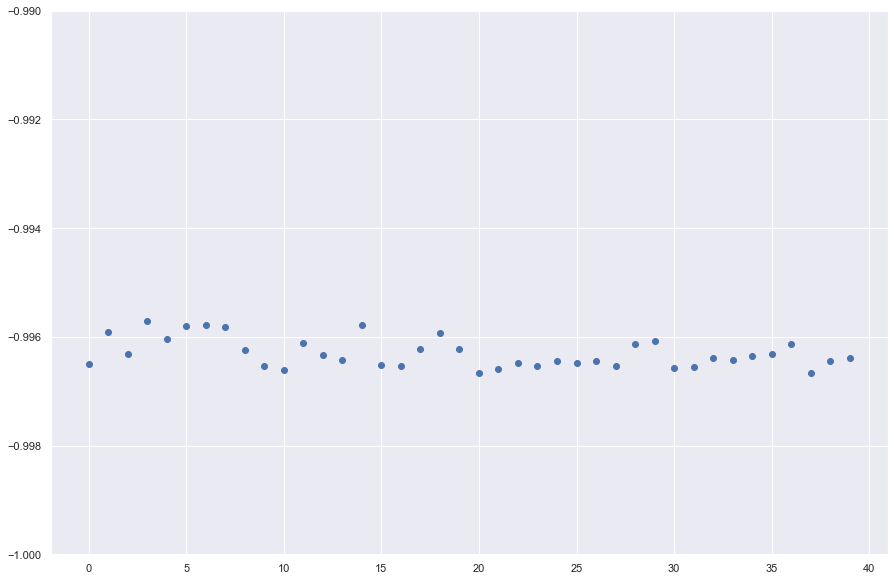

In [44]:
# Extract and plot the trials losses
plt.scatter(range(len(trials.losses())), trials.losses())
ax = plt.gca()
ax.set_ylim([-1, -0.99])

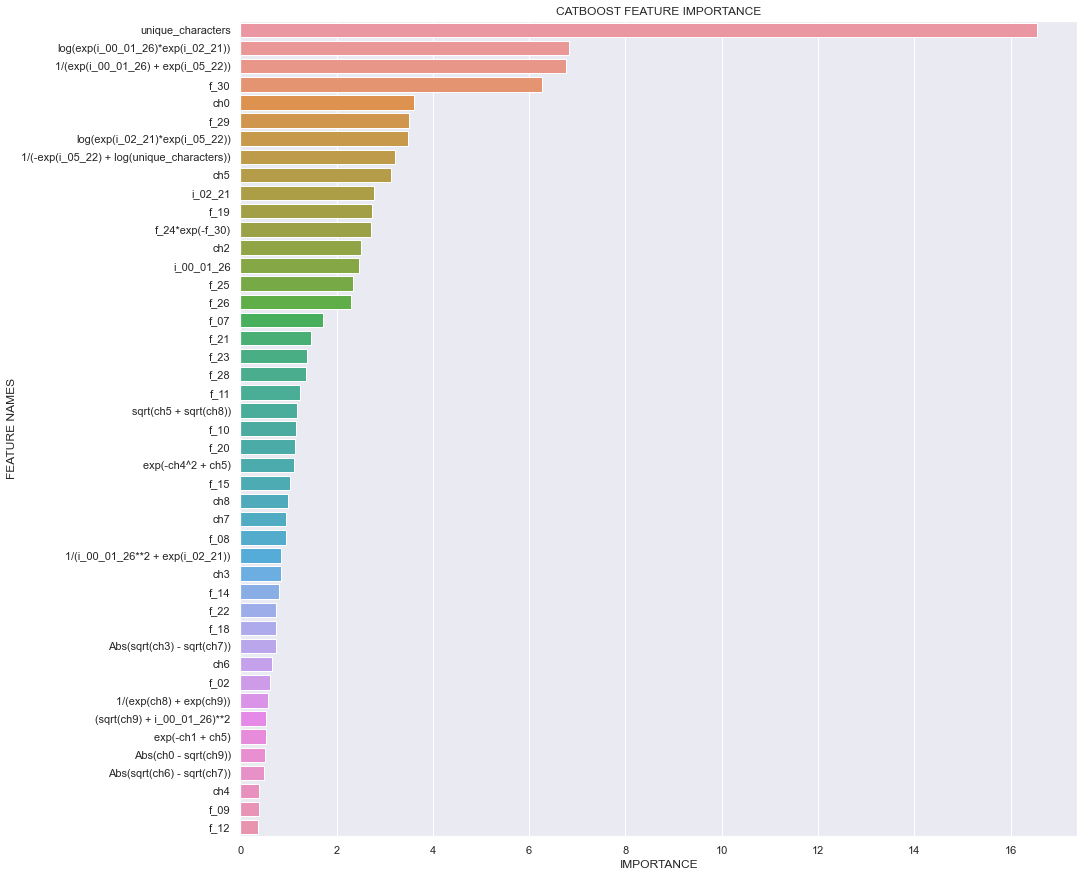

In [45]:
plot_feature_importance(ctb.feature_importances_, features, 'CATBOOST ', max_features=45)

In [ ]:
fit_parameters = {'early_stopping_rounds': 100,
                  'verbose': 100
                  # 'plot': True
                  }
train_pred_hyperopt_model([best_hyperparams], [CatBoostClassifier], train_prep, train_targets, test_prep, ids, model_fit_parameters=[fit_parameters], n_folds=8, random_seed=True, save_model=True, eval_x=eval_prep, train_val_split=0.95)

# SHAP analyse

In [43]:
X_val_pd = pd.DataFrame(X_val, columns=features)
X_val_pd

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0       2.047486  0.942956  1.325293  1.322427 -0.556954  1.090672  0.381835   
1       0.500110  0.804661 -1.112907 -0.403102 -0.203863  1.043791 -0.640442   
2       0.010399  1.524480 -0.017614 -0.591790 -0.575994 -0.056169  1.064248   
3      -0.053362 -1.516061 -0.740540 -0.777793 -0.464684 -0.855372 -1.579461   
4      -0.618566 -0.446105 -2.369097 -1.134176  0.423352 -1.744644  0.743429   
...          ...       ...       ...       ...       ...       ...       ...   
119995 -0.076154 -0.486665 -0.015609  0.364342 -0.361674  1.201038 -1.698609   
119996  0.247510 -0.114478  0.696710 -0.259084 -0.075833 -0.907625 -2.024800   
119997 -2.981547  1.099332  0.790412 -0.809525 -1.124243 -0.341392  0.778587   
119998 -1.518982  0.461855 -0.128184  1.053919 -0.210332  1.505763  0.563242   
119999 -0.012240 -1.296157 -0.226766  0.431225  0.683563 -0.746960  0.425539   

            f_07      f_08      f_09  ...  sqrt(ch5 + sqrt(ch8))  \
0      -0.018996  1.220653 -0.221304  ...               0.709996   
1      -0.622798 -0.665008 -0.221304  ...              -0.460253   
2       1.188609  0.592099 -0.831915  ...               0.919454   
3      -0.622798 -0.036455 -0.831915  ...               1.086736   
4      -0.622798 -0.036455  0.389306  ...               0.415074   
...          ...       ...       ...  ...                    ...   
119995 -1.226600 -0.036455  0.999917  ...               0.709996   
119996  1.188609 -0.665008  0.389306  ...              -0.460253   
119997 -0.622798  0.592099  0.389306  ...               0.207683   
119998 -0.018996 -0.036455 -0.221304  ...               0.709996   
119999 -1.226600  0.592099  0.389306  ...              -0.460253   

        Abs(sqrt(ch3) - sqrt(ch7))  Abs(ch0 - sqrt(ch9))  exp(-ch4^2 + ch5)  \
0                         0.228634             -1.399441           0.284460   
1                         0.433219              1.806380           0.284460   
2                        -1.021465              0.034246          -0.781591   
3                         0.617248             -0.349910           2.212212   
4                         0.403308              1.083777          -0.816899   
...                            ...                   ...                ...   
119995                   -0.604119              0.034246           0.284460   
119996                    0.020861             -0.805589          -0.837447   
119997                    0.403308              0.034246          -0.424721   
119998                   -0.723271             -0.349910           0.284460   
119999                    0.409474             -1.399441           0.284460   

        exp(-ch1 + ch5)  f_24*exp(-f_30)  1/(exp(i_00_01_26) + exp(i_05_22))  \
0              0.578720        -0.082429                            0.053754   
1             -0.275158         0.023087                            0.053754   
2             -0.275158        -0.320407                            0.053754   
3             -0.747353        -0.056289                            0.053754   
4             -0.704841         1.901850                            0.053754   
...                 ...              ...                                 ...   
119995         0.578720         0.473984                            0.053754   
119996        -0.747353         0.185423                            0.053754   
119997        -0.275158         0.171929                            0.053754   
119998         0.578720         0.238552                            0.053754   
119999         2.899799         0.480094                            2.825482   

        log(exp(i_00_01_26)*exp(i_02_21))  log(exp(i_02_21)*exp(i_05_22))  \
0                               -0.033253                         0.00766   
1                               -0.033253                         0.00766   
2                               -0.033253                         0.00766   
3               

In [44]:
# Using a random sample of the dataframe for better time computation
# X_sampled = X_val_pd.sample(2000, random_state=2022)
X_sampled = X_val_pd.iloc[:2000]
Y_sampled = y_val[:2000]

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_sampled)

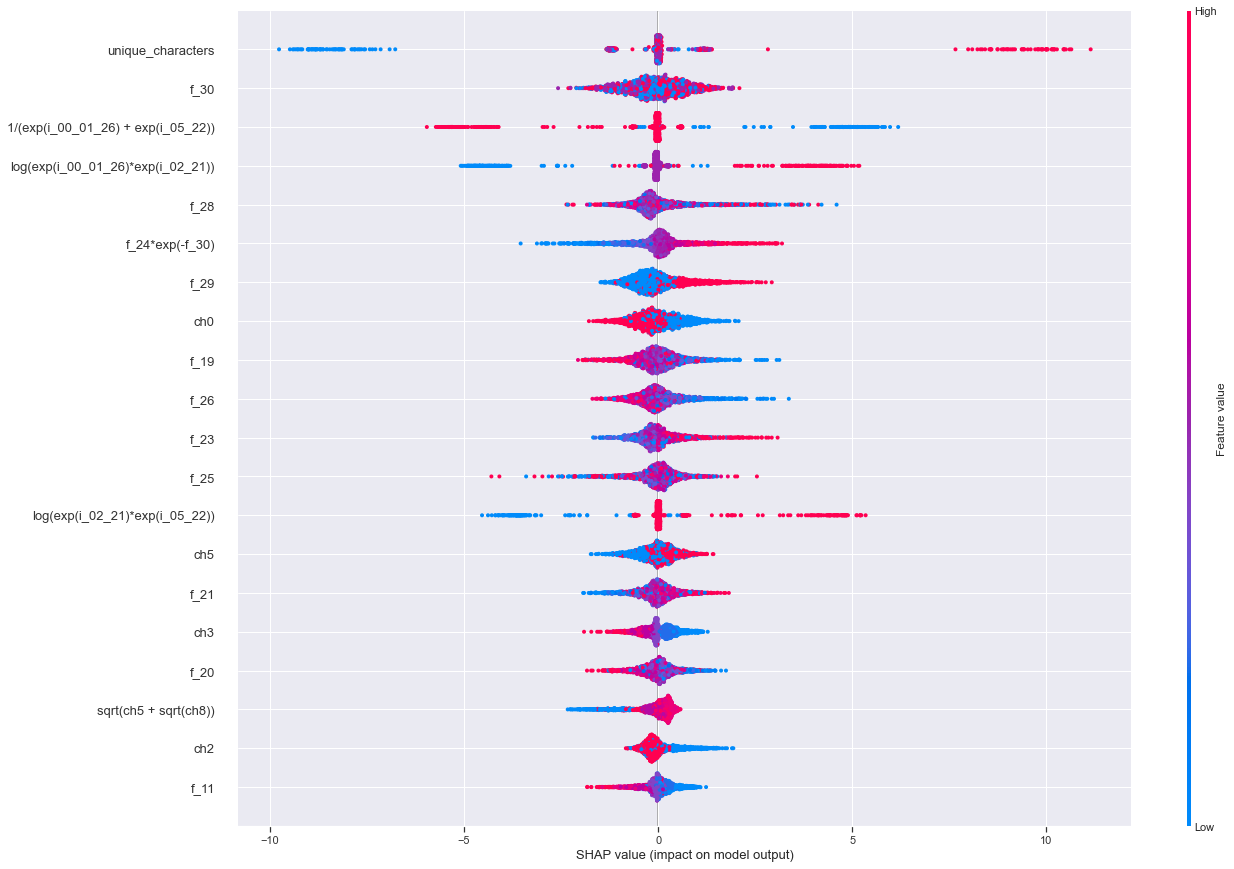

In [45]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled, plot_size=(20,15))

In [20]:
# plot the effects of a single feature
shap.initjs()
shap.force_plot(Y_sampled[0], shap_values[0,:], X_sampled.iloc[0,:])

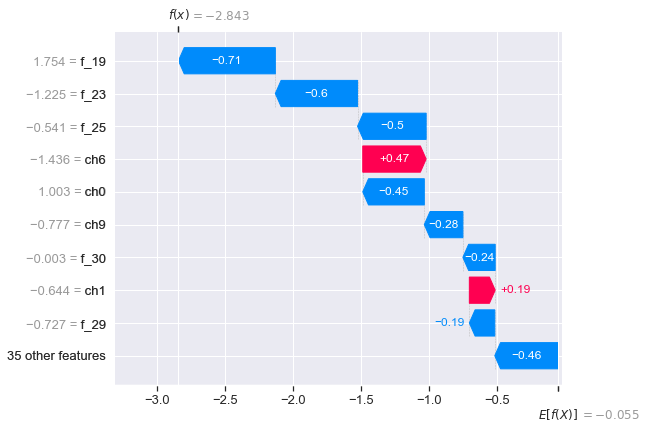

In [53]:
shap.plots.waterfall(shap_values[0])

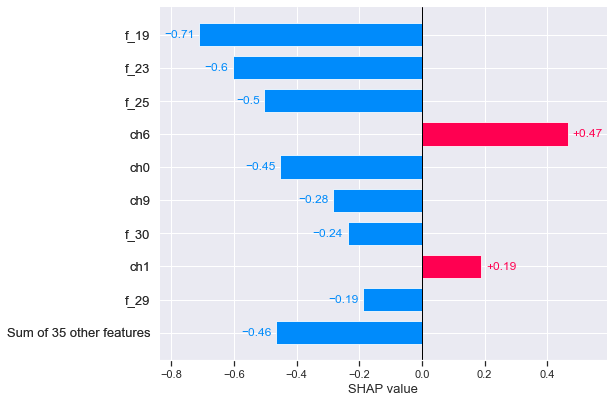

In [55]:
shap.plots.bar(shap_values[0])

In [46]:
shap_interaction = shap.TreeExplainer(xgb).shap_interaction_values(X_sampled)
# shap_values = ctb.get_feature_importance(Pool(data[X_sampled.columns]),type=EFstrType.ShapValues,verbose=100)
# shap_interaction = ctb.get_feature_importance(Pool(X_sampled),type=EFstrType.ShapInteractionValues,verbose=100)

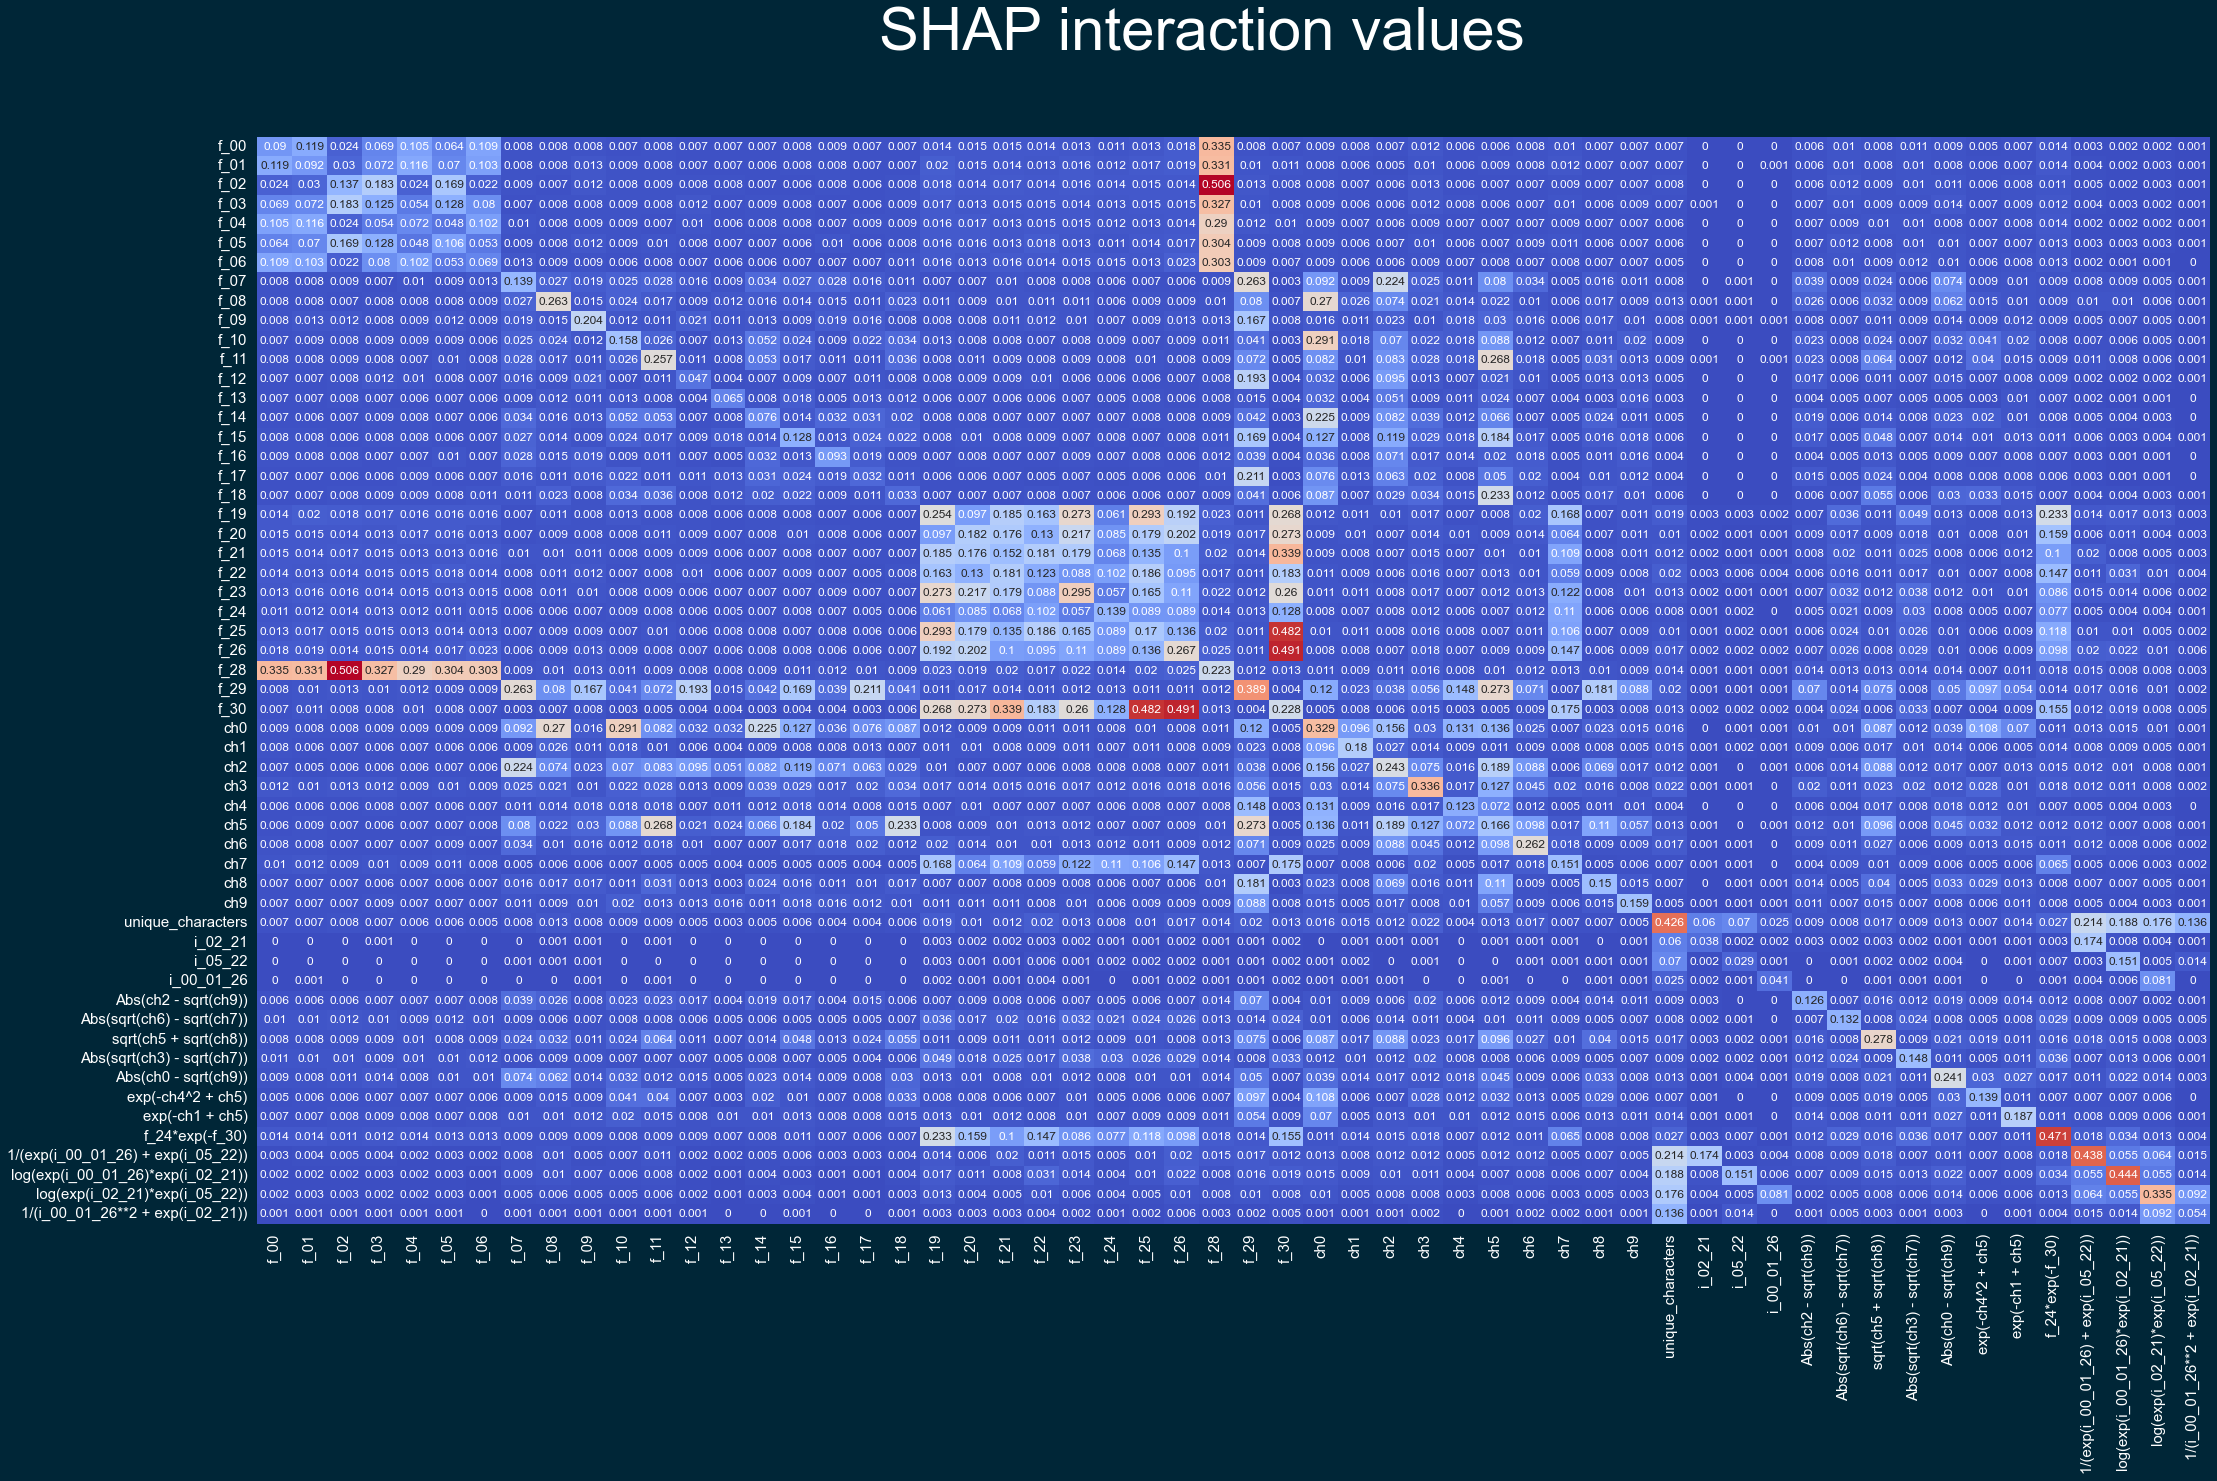

In [47]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, columns=features)#, index=)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, yticklabels=features, xticklabels=features)
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0)
plt.show()

In [38]:
explainer2 = shap.Explainer(xgb)
shap_values2 = explainer(X_sampled)

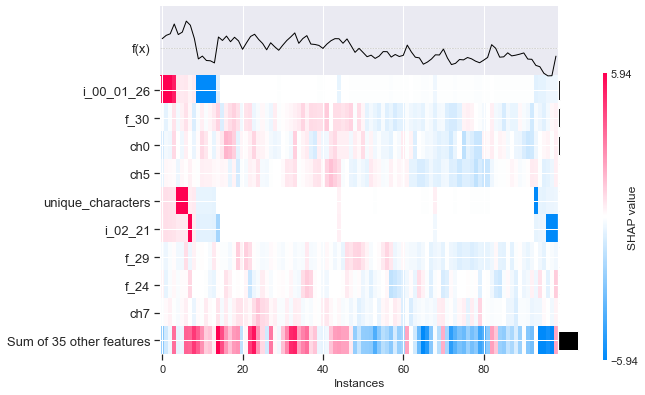

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

In [51]:
shap.plots.heatmap(shap_values2[1:100])

# Ensemble submission

### np_test, np_eval

In [47]:
train_prep.shape, train_targets.shape, eval_prep.shape, eval_targets.shape, test_prep.shape

((720000, 60), (720000,), (180000, 60), (180000,), (700000, 60))

In [48]:
eval_samples = eval_prep.shape[0]
directory = 'predictions/'
all_preds=[]
n_models = 0
eval_dict = {}
test_dict = {}
filenames = []
for filename in os.scandir(directory):
    if filename.is_file():
        file_path = filename.path.replace('\\','/')

        predictions = import_data(file_path)

        eval_dict[filename.name] = predictions['eval']
        test_dict[filename.name] = predictions['test']

        filenames.append(filename.name)

np_eval = np.asarray(pd.DataFrame.from_dict(eval_dict))[:eval_samples]
np_test = np.asarray(pd.DataFrame.from_dict(test_dict))


--------------------------------------------------
Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 2.67 MB
Decreased by 75.0%
--------------------------------------------------
--------------------------------------------------
Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 2.67 MB
Decreased by 75.0%
--------------------------------------------------
--------------------------------------------------
Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 2.67 MB
Decreased by 75.0%
--------------------------------------------------
--------------------------------------------------
Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 2.67 MB
Decreased by 75.0%
--------------------------------------------------
--------------------------------------------------
Memory usage of dataframe is 10.68 MB
Memory usage after optimization is: 2.67 MB
Decreased by 75.0%
------------------------------------

In [49]:
np_eval.shape, eval_targets.shape, np_test.shape

((180000, 13), (180000,), (700000, 13))

### XGB submission

In [50]:
eval_X_train, eval_y_train, eval_X_val, eval_y_val = train_test_split(np_eval, eval_targets, test_size=0.2)

eval_X_train.shape, eval_y_train.shape, eval_X_val.shape, eval_y_val.shape

((144000, 13), (144000,), (36000, 13), (36000,))

In [55]:
space_eval_xgb={'max_depth': scope.int(hp.quniform("max_depth", 4, 15, 1)),
       'gamma': hp.uniform ('gamma', 0.5,5),
       'reg_alpha' : hp.uniform('reg_alpha', 1,5),
       'reg_lambda' : hp.uniform('reg_lambda', 1,5),
       'colsample_bytree' : hp.uniform ('colsample_bytree', 0.5,0.9),
       'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
       'n_estimators': scope.int(hp.quniform("n_estimators", 512, 4048, 1)),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
       'subsample': hp.uniform('subsample', 0.5, 1),
       'objective': hp.choice('objective', ['binary:logistic']),
       'tree_method': hp.choice('tree_method', ['gpu_hist']),
       }

In [58]:
def xgb_eval_objective(space_):
    model=XGBClassifier(
        n_estimators = space_['n_estimators'],
        max_depth = space_['max_depth'],
        gamma = space_['gamma'],
        reg_alpha = space_['reg_alpha'],
        reg_lambda = space_['reg_lambda'],
        min_child_weight=space_['min_child_weight'],
        learning_rate=space_['learning_rate'],
        subsample=space_['subsample'],
        objective=space_['objective'],
        tree_method=space_['tree_method'],
        colsample_bytree=space_['colsample_bytree'])

    model.fit(eval_X_train, eval_y_train,
              eval_set = [(eval_X_val, eval_y_val)],
              eval_metric="auc",
              early_stopping_rounds=100,
              verbose=False)

    pred = model.predict_proba(eval_X_val)[:, 1]
    score = roc_auc_score(eval_y_val, pred)
    accuracy = accuracy_score(eval_y_val, pred>0.5)
    #print (f"ROC_AUC SCORE: {score} | ACCURACY SCORE: {accuracy}")
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [59]:
trials = Trials()

best_hyperparams = fmin(fn = xgb_eval_objective,
                        space = space_eval_xgb,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

best_hyperparams = space_eval(space_eval_xgb, best_hyperparams)

100%|██████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: -0.9980727103390566]


In [60]:
xgb = XGBClassifier(**best_hyperparams)
hist = xgb.fit(eval_X_train, eval_y_train,
               eval_set = [(eval_X_val, eval_y_val)],
               eval_metric = ['auc', 'logloss'],
               early_stopping_rounds = 100,
               verbose = 100)

[0]	validation_0-auc:0.99594	validation_0-logloss:0.60062
[100]	validation_0-auc:0.99807	validation_0-logloss:0.05586
[194]	validation_0-auc:0.99807	validation_0-logloss:0.05590


(-1.0, -0.99)

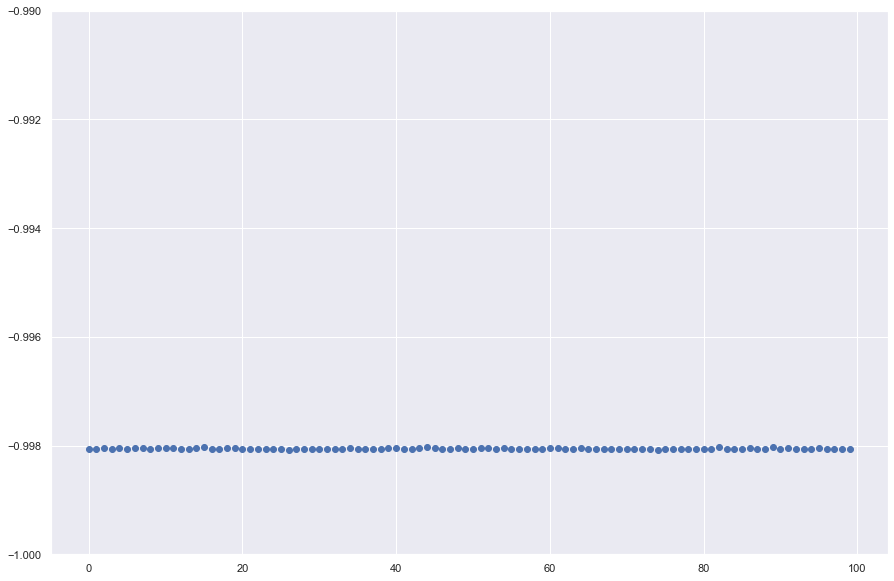

In [61]:
# Extract and plot the trials losses
plt.scatter(range(len(trials.losses())), trials.losses())
ax = plt.gca()
ax.set_ylim([-1, -0.99])

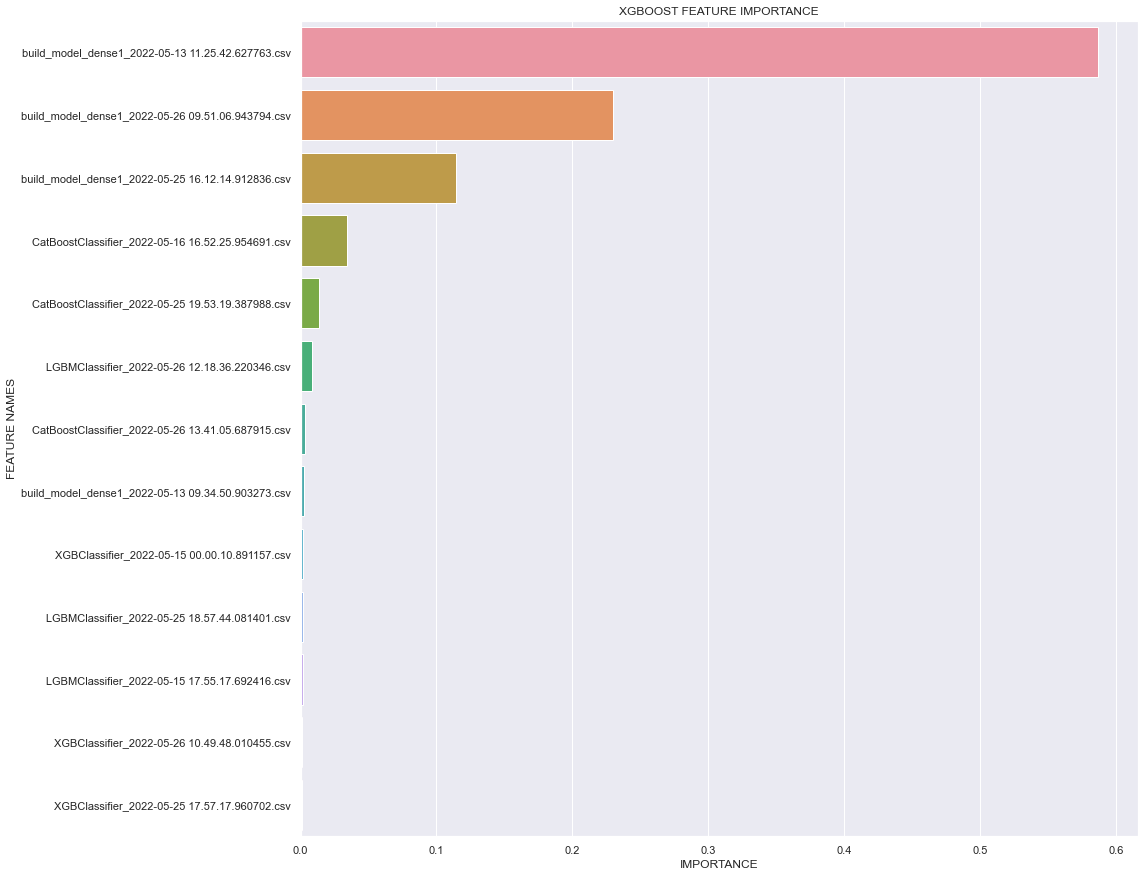

In [62]:
plot_feature_importance(xgb.feature_importances_, filenames, 'XGBOOST ', max_features=20)

In [63]:
fit_parameters = {'early_stopping_rounds': 100,
                  'verbose': 100,
                  'eval_metric': ['auc', 'logloss']
                  }
train_pred_hyperopt_model([best_hyperparams], [XGBClassifier], np_eval, eval_targets, np_test, ids, model_fit_parameters=[fit_parameters], n_folds=20, random_seed=True, save_model=False)

Fold: 1/20
[0]	validation_0-auc:0.99576	validation_0-logloss:0.60060
[100]	validation_0-auc:0.99810	validation_0-logloss:0.05473
[200]	validation_0-auc:0.99810	validation_0-logloss:0.05474
[231]	validation_0-auc:0.99810	validation_0-logloss:0.05475
Fold: 2/20
[0]	validation_0-auc:0.99562	validation_0-logloss:0.60088
[100]	validation_0-auc:0.99793	validation_0-logloss:0.05764
[200]	validation_0-auc:0.99793	validation_0-logloss:0.05765
[267]	validation_0-auc:0.99793	validation_0-logloss:0.05767
Fold: 3/20
[0]	validation_0-auc:0.99580	validation_0-logloss:0.60073
[100]	validation_0-auc:0.99797	validation_0-logloss:0.05686
[200]	validation_0-auc:0.99797	validation_0-logloss:0.05684
[246]	validation_0-auc:0.99797	validation_0-logloss:0.05684
Fold: 4/20
[0]	validation_0-auc:0.99505	validation_0-logloss:0.60077
[100]	validation_0-auc:0.99806	validation_0-logloss:0.05566
[197]	validation_0-auc:0.99806	validation_0-logloss:0.05567
Fold: 5/20
[0]	validation_0-auc:0.99564	validation_0-logloss:0.6

### DNN submission

In [87]:
def build_model_dnn_submission(hp):
    model = tf.keras.Sequential()
    model.add(Dense(units=hp.Int("units_dense_1", min_value=16, max_value=128, step=32)))


    for i in range(hp.Int('num_layers_dense', 2, 5)):
        model.add(Dense(hp.Int('units_dense' + str(i), min_value=16, max_value=128, step=16), activation= hp.Choice('activation_dense' + str(i), ['relu', 'selu', 'tanh', 'elu', 'swish'])))#, kernel_regularizer='l1_l2'))

    #model.add(Dropout(hp.Float("dropout_rate_dense_1", min_value=0.1, max_value=0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizier_list=[tf.keras.optimizers.Adam,
                     tf.keras.optimizers.RMSprop,
                     tf.keras.optimizers.Nadam,
                     tf.keras.optimizers.Adagrad]

    hp_learning_rate = hp.Choice("learning_rate", values=[5e-4, 5e-5, 5e-6])
    hp_optimizer = hp.Choice("optimizer", values=[0,1,2,3])

    model.compile(loss='binary_crossentropy', optimizer=optimizier_list[hp_optimizer](learning_rate=hp_learning_rate), metrics=['AUC'])

    return model

In [94]:
tuner = get_tuner(build_model_dnn_submission, 'bayesian', max_trials=30)

Getting Bayesian keras tuner..
Search space summary
Default search space size: 8
units_dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': None}
num_layers_dense (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_dense0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_dense0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'tanh', 'elu', 'swish'], 'ordered': False}
units_dense1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_dense1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'tanh', 'elu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.0005, 'conditions': [], 'values': [0.0005, 5e-05, 5e-06], 'ordered': True}
optimizer (Choice)
{'default': 0, 'conditions': [], 'val

In [95]:
eval_X_train, eval_y_train, eval_X_val, eval_y_val = train_test_split(np_eval, eval_targets, test_size=0.2)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tuner.search(eval_X_train, eval_y_train,
             validation_data=(eval_X_val, eval_y_val),
             epochs=15, callbacks=[stop_early], verbose=2, batch_size = 1024)

Trial 30 Complete [00h 00m 06s]
val_auc: 0.9976664185523987

Best val_auc So Far: 0.9978452324867249
Total elapsed time: 00h 04m 49s
INFO:tensorflow:Oracle triggered exit


In [72]:
tuner.get_best_hyperparameters(1)[0].values

{'units_dense_1': 32,
 'num_layers_dense': 8,
 'units_dense0': 32,
 'activation_dense0': 'relu',
 'units_dense1': 32,
 'activation_dense1': 'relu',
 'dropout_rate_dense_1': 0.6,
 'learning_rate': 0.0005,
 'optimizer': 0,
 'units_dense2': 320,
 'activation_dense2': 'relu',
 'units_dense3': 32,
 'activation_dense3': 'relu',
 'units_dense4': 128,
 'activation_dense4': 'relu',
 'units_dense5': 32,
 'activation_dense5': 'swish',
 'units_dense6': 512,
 'activation_dense6': 'relu',
 'units_dense7': 512,
 'activation_dense7': 'selu'}

In [96]:
train_pred_tuner_models(tuner, build_model_dnn_submission, np_eval, eval_targets, np_test, ids, n_models=1, n_folds=8, random_seed=True, save_model=True)

Epoch 1/25
1125/1125 - 2s - loss: 0.5054 - auc: 0.9714 - val_loss: 0.3905 - val_auc: 0.9974
Epoch 2/25
1125/1125 - 2s - loss: 0.3371 - auc: 0.9956 - val_loss: 0.2815 - val_auc: 0.9973
Epoch 3/25
1125/1125 - 2s - loss: 0.2382 - auc: 0.9966 - val_loss: 0.1906 - val_auc: 0.9975
Epoch 4/25
1125/1125 - 2s - loss: 0.1586 - auc: 0.9969 - val_loss: 0.1254 - val_auc: 0.9974
Epoch 5/25
1125/1125 - 2s - loss: 0.1086 - auc: 0.9969 - val_loss: 0.0896 - val_auc: 0.9974
Epoch 6/25
1125/1125 - 2s - loss: 0.0839 - auc: 0.9971 - val_loss: 0.0740 - val_auc: 0.9976
Epoch 7/25
1125/1125 - 2s - loss: 0.0737 - auc: 0.9971 - val_loss: 0.0678 - val_auc: 0.9974
Epoch 8/25
1125/1125 - 2s - loss: 0.0698 - auc: 0.9971 - val_loss: 0.0654 - val_auc: 0.9977
Epoch 9/25
1125/1125 - 2s - loss: 0.0684 - auc: 0.9973 - val_loss: 0.0645 - val_auc: 0.9974
Epoch 10/25
1125/1125 - 2s - loss: 0.0678 - auc: 0.9971 - val_loss: 0.0641 - val_auc: 0.9972
Epoch 11/25
1125/1125 - 2s - loss: 0.0674 - auc: 0.9971 - val_loss: 0.0637 - va